---
# **Classification of Biomedical Texts with Deep Learning: LSTM, GRU, and Soft-Attention**

---

In biomedical text classification, datasets are often highly imbalanced, with some categories (e.g., rare diseases or specific biomedical events) severely underrepresented compared to others. This imbalance can lead to biased model performance, where deep learning models tend to favor the majority class, overlooking critical but rare information.

To overcome this challenge during the selection phase of our pipeline, we explore a range of resampling techniques aimed at improving the robustness and fairness of our models: **SMOTE** (Synthetic Minority Over-sampling Technique),
**Borderline-SMOTE** and **Class Weights**.

These techniques are applied across our deep learning architectures — LSTM, GRU, and GRU with Bahdanau Self-Attention — to evaluate their impact on key classification metrics such as F1 Score, Balanced Accuracy, Recall, and Precision.

By tackling class imbalance head-on, we aim to build models that are not only accurate but also equitable, especially in critical biomedical applications where every class — no matter how small — matters.

In [1]:
import random
import re
import time
from tqdm import tqdm
from collections import defaultdict, Counter
import numpy as np
import torch
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix,
                             classification_report, balanced_accuracy_score,
                             precision_score, recall_score, ConfusionMatrixDisplay)
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data.dataset import ConcatDataset
import torch.nn as nn
import torch.optim as optim
import wandb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# To ensure reproducibility of the results
SEED = 200
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv('/content/drive/MyDrive/binary_diseases_dataset.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28406 entries, 0 to 28405
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   PMID              28406 non-null  int64 
 1   Title             28406 non-null  object
 2   Abstract          28406 non-null  object
 3   Keywords          28406 non-null  object
 4   PublicationYear   28406 non-null  int64 
 5   MeSH_Terms        28406 non-null  object
 6   Cleaned_Abstract  28406 non-null  object
 7   Disease           28406 non-null  object
 8   Label             28406 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 2.0+ MB


Let's determining the number of samples of each class.

In [ ]:
print("Original class distribution:")
print(Counter(data['Label']))

Original class distribution:
Counter({1: 18965, 0: 9441})


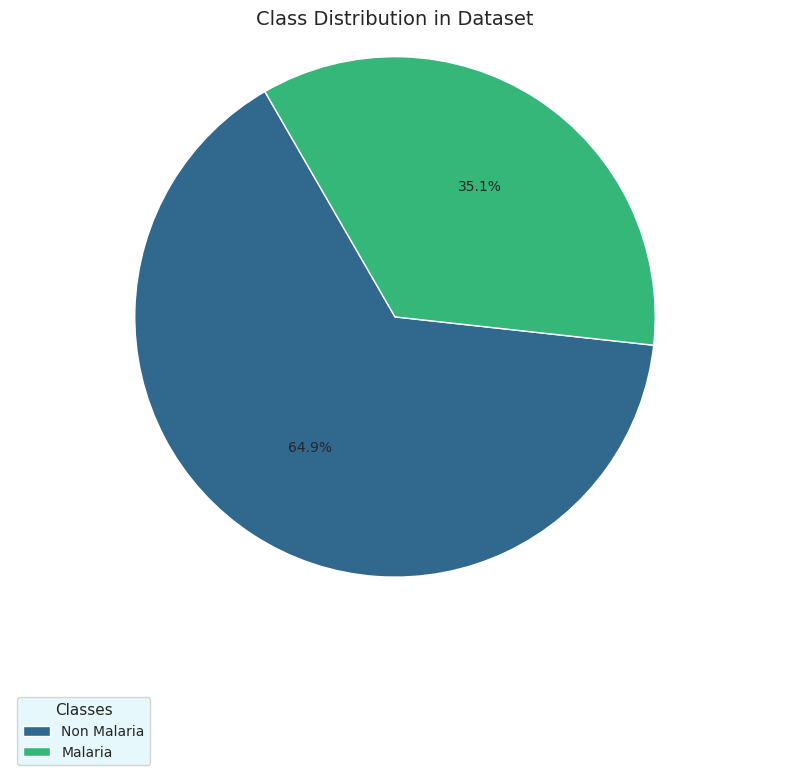

In [5]:
class_names_dict = {
    0: 'Non Malaria',
    1: 'Malaria',
}

label_counts = Counter(data['Label'])
label_counts_named = {class_names_dict.get(k, k): v for k, v in label_counts.items()}
label_df = pd.DataFrame.from_dict(label_counts_named, orient='index').reset_index()
label_df.columns = ['Label', 'Count']
label_df = label_df.sort_values(by='Count', ascending=False)

sns.set_style("darkgrid", {
    "grid.color": ".4",
    "grid.linestyle": "-",
    "axes.facecolor": "#e0f7fa"
})

custom_colors = sns.color_palette("viridis", n_colors=len(label_df))

fig, ax = plt.subplots(figsize=(8, 8))

wedges, texts, autotexts = ax.pie(label_df['Count'],
                                  labels=None,
                                  autopct='%1.1f%%',
                                  startangle=120,
                                  colors=custom_colors,
                                  wedgeprops=dict(edgecolor='white'))

ax.legend(wedges,
          label_df['Label'],
          title="Classes",
          loc="lower left",
          bbox_to_anchor=(0, -0.3),
          fontsize=10,
          title_fontsize=11)

ax.set_title('Class Distribution in Dataset', fontsize=14)
ax.axis('equal')

plt.tight_layout()
plt.show()

In [6]:
X = data["Cleaned_Abstract"].values
y = data["Label"].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 18818 samples
Validation set: 4032 samples
Test set: 4033 samples


In [7]:
def tokenize(text):
    """
    Tokenizes the input text by converting it to lowercase and splitting it into words.

    Args:
        text: A string containing the text to be tokenized.

    Returns:
        A list of tokens (words) from the text.
    """
    return re.findall(r'\b\w+\b', text.lower())

In [8]:
all_tokens = [token for text in X_train for token in tokenize(text)]
vocab = Counter(all_tokens)
filtered_vocab = {word: freq for word, freq in vocab.items() if freq >= 2}
VOCAB_SIZE =  40000

sorted_filtered_vocab = dict(sorted(filtered_vocab.items(), key=lambda item: item[1], reverse=True)[:VOCAB_SIZE])

word_to_index = {word: idx for idx, (word, _) in enumerate(sorted_filtered_vocab.items(), 1)}
word_to_index["<PAD>"] = 0
word_to_index["<UNK>"] = len(word_to_index)

index_to_word = {idx: word for word, idx in word_to_index.items()}
print(word_to_index["malaria"])
print(index_to_word[1])

print(index_to_word[300])
print(word_to_index["host"])

1
malaria
interaction
28


In [9]:
def text_to_sequence(text):
    """
    Converts the tokenized text into a sequence of indices based on a word-to-index mapping.

    Args:
        text: A string containing the text to be converted.

    Returns:
        A list of integers representing the sequence of token indices.
    """
    return [word_to_index.get(token, word_to_index["<UNK>"]) for token in tokenize(text)]

def pad_to_tensor(sequences, max_len=None):
    """
    Pads sequences to the specified maximum length, or truncates them if they exceed it.

    Args:
        sequences: A list of sequences (each sequence is a list of integers).
        max_len: The maximum length to which sequences should be padded. If None, no padding is applied.

    Returns:
        A tensor containing the padded (or truncated) sequences.
    """
    padded_sequences = [torch.tensor(seq, dtype=torch.long) for seq in sequences]
    if max_len:
        padded_sequences = [seq[:max_len] for seq in padded_sequences]
        padded_sequences = [
            torch.cat([seq, torch.zeros(max_len - len(seq), dtype=torch.long)], 0) if len(seq) < max_len else seq
            for seq in padded_sequences
        ]

    return torch.stack(padded_sequences)

class TextDataset(Dataset):
    """
    Custom Dataset for handling text data and labels.

    Args:
        X_data: Input features (e.g., tokenized text).
        y_data: Labels corresponding to the text data.
        raw_text_data: (Optional) The raw text data for reference (default is None).
    """
    def __init__(self, X_data, y_data, raw_text_data=None):
        self.X = torch.tensor(X_data, dtype=torch.long)
        self.y = torch.tensor(y_data, dtype=torch.long)
        self.raw_text_data = raw_text_data

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        input_tensor = self.X[idx]
        target_tensor = self.y[idx]

        raw_text = None
        if self.raw_text_data is not None and idx < len(self.raw_text_data):
            raw_text = self.raw_text_data[idx]

        return input_tensor, target_tensor, raw_text

def custom_collate_fn(batch):
    inputs, targets, raw_texts = zip(*batch)
    inputs = torch.stack(inputs)
    targets = torch.stack(targets)
    return inputs, targets, list(raw_texts)

def load_glove_embeddings(glove_path, word_to_index, embedding_dim):
    """Loads GloVe embeddings and returns an embedding matrix."""
    embedding_matrix = np.zeros((len(word_to_index), embedding_dim), dtype='float32')
    with open(glove_path, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            if word in word_to_index:
                vector = np.asarray(values[1:], dtype='float32')
                embedding_matrix[word_to_index[word]] = vector

    return torch.tensor(embedding_matrix, dtype=torch.float)

In [10]:
EMBEDDING_DIM = 300
embedding_matrix = load_glove_embeddings('/content/drive/MyDrive/glove/glove.6B.300d.txt', word_to_index, EMBEDDING_DIM)

X_train_seq = [text_to_sequence(text) for text in X_train]
X_val_seq = [text_to_sequence(text) for text in X_val]
X_test_seq = [text_to_sequence(text) for text in X_test]

print(X_train_seq[0])

[601, 22, 41, 202, 1, 54, 10360, 12405, 1996, 26, 2135, 1985, 1119, 1706, 115, 159, 39, 317, 9337, 1104, 155, 1119, 403, 5672, 2618, 790, 34, 413, 5, 331, 368, 534, 232, 728, 482, 263, 3719, 88, 83, 403, 15, 1119, 1141, 2948, 856, 15, 96, 6211, 1823, 3691, 53, 705, 1198, 53, 1324, 61, 505, 6, 210, 143, 32, 497, 1060, 1198, 174, 53, 817, 1119, 1141, 17, 48, 728, 3719, 2432, 34371, 5483, 7312, 34371, 5483, 6, 6871, 10, 84, 40001, 1584, 666, 120, 48, 931, 21, 193, 5, 368, 3719, 88, 40001, 4945, 568, 88, 6979, 2393, 15, 10, 7312, 6871, 88, 77, 82, 86, 568, 40001, 278, 7, 3, 34372, 278, 7, 3, 40001, 1757, 1974, 77, 2393, 2393, 195, 3, 12888, 9, 3, 362, 42, 65, 3, 8847, 9, 3, 362, 42, 65, 91, 21, 47, 3720, 3282, 1761, 3823, 483, 2936, 5191, 7312, 541, 7, 325, 732, 75, 443, 732, 12, 86, 1619, 195, 7801, 948, 54, 279, 1619, 195, 8456, 1676, 195, 6871, 42, 7, 182, 182, 743, 54, 91, 50, 5, 77, 7312, 6871, 10361, 27, 534, 4621, 403, 1119, 1141, 1456, 1368, 3474, 156, 1, 1475, 1414, 1840, 41, 202,

In [11]:
max_length = 400

X_train_tensor = pad_to_tensor(X_train_seq, max_len=max_length)
X_val_tensor = pad_to_tensor(X_val_seq, max_len=max_length)
X_test_tensor = pad_to_tensor(X_test_seq, max_len=max_length)

print(f"Train Tensor Shape: {X_train_tensor.shape}, Type: {X_train_tensor.dtype}")
print(f"Validation Tensor Shape: {X_val_tensor.shape}, Type: {X_val_tensor.dtype}")
print(f"Test Tensor Shape: {X_test_tensor.shape}, Type: {X_test_tensor.dtype}")

y_train_tensor = torch.tensor(y_train)
y_val_tensor = torch.tensor(y_val)
y_test_tensor = torch.tensor(y_test)

Train Tensor Shape: torch.Size([18818, 400]), Type: torch.int64
Validation Tensor Shape: torch.Size([4032, 400]), Type: torch.int64
Test Tensor Shape: torch.Size([4033, 400]), Type: torch.int64


In [12]:
class GRU_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=1,
                 num_layers=1, dropout_prob=0.3,
                 embedding_weights=None, freeze_embeddings=True):
        super().__init__()
        if embedding_weights is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=freeze_embeddings)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers,
                          batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        _, hidden = self.gru(embedded)
        out = self.fc(self.dropout(hidden[-1]))
        return out


class LSTM_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=1,
                 num_layers=1, dropout_prob=0.3,
                 embedding_weights=None, freeze_embeddings=True):
        super().__init__()
        if embedding_weights is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=freeze_embeddings)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        out = self.fc(self.dropout(hidden[-1]))
        return out

In [13]:
clip = 5.0

def epoch_time(start_time, end_time):
    elapsed = end_time - start_time
    return int(elapsed / 60), int(elapsed % 60)

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for inputs, labels, _ in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device).float()  # <-- cast en float ici

        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)

        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        preds = (torch.sigmoid(outputs) >= 0.5).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_balanced_acc = balanced_accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_balanced_acc

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels, _ in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            preds = (torch.sigmoid(outputs) >= 0.5).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, pos_label=1, zero_division=0)

    return epoch_loss, balanced_acc, f1


def get_hidden_states(model, dataloader, device):
    """
    This function extracts the hidden states from a model (either GRU or LSTM) for each sample in the dataloader.
    The hidden states are taken from the last time step of the sequence, which are typically used for classification tasks.

    Args:
        model: A PyTorch model that contains an embedding layer and either a GRU or LSTM layer.
        dataloader: A DataLoader containing batches of input data and their corresponding targets.
        device: The device (CPU or GPU) to run the model on.

    Returns:
        hidden_states: A numpy array containing the hidden states for each sample in the dataloader.
        labels: A numpy array containing the target labels corresponding to each input sample.
    """
    model.eval()
    hidden_states, labels = [], []

    with torch.no_grad():
        for inputs, targets, _ in dataloader:
            inputs = inputs.to(device)
            embedded = model.embedding(inputs)

            if hasattr(model, "gru"):
                output, _ = model.gru(embedded)
                state = output[:, -1, :]
            elif hasattr(model, "lstm"):
                _, (state, _) = model.lstm(embedded)
                state = state[-1]
            else:
                raise ValueError("Model must contain GRU or LSTM.")

            hidden_states.append(state.cpu().numpy())
            labels.append(targets.numpy())

    return np.concatenate(hidden_states), np.concatenate(labels)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

---
# I. **SMOTE (Synthetic Minority Over-sampling Technique)**

---

**SMOTE (Synthetic Minority Over-sampling Technique)** is a method used to deal with class imbalance problems in datasets. It works by generating synthetic data for the minority class, rather than simply repeating existing examples. SMOTE creates new samples by interpolating the minority class examples with their nearest neighbours in feature space. This technique increases the representation of the minority class, reducing the model's bias towards the majority class. It is often used before training the model to balance the classes without losing important information.

In [16]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tensor, y_train_tensor)

X_val_resampled, y_val_resampled = X_val_tensor, y_val_tensor
X_test_resampled, y_test_resampled = X_test_tensor, y_test_tensor

In [17]:
batch_size = 16
train_dataset = TextDataset(X_train_resampled, y_train_resampled, raw_text_data=X_train)
val_dataset = TextDataset(X_val_tensor, y_val, raw_text_data=X_val)
test_dataset = TextDataset(X_test_tensor, y_test, raw_text_data=X_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

combined_dataset = ConcatDataset([train_dataset, val_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 24468
Validation set size: 4032
Test set size: 4033


<ipython-input-9-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)


---
## I.1 **SMOTE - LSTM - Glove**

## Validation phase

In [ ]:
model = LSTM_Model(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=350,
    num_layers=1,
    dropout_prob=0.3,
    embedding_weights=embedding_matrix,
    freeze_embeddings=False
).to(device)

print(model)
num_params = count_parameters(model)
print()
print(f"Total trainable parameters: {num_params}")

LSTM_Model(
  (embedding): Embedding(40002, 300)
  (lstm): LSTM(300, 350, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=350, out_features=1, bias=True)
)

Total trainable parameters: 12913751


In [ ]:
model.eval()
embeddings = []
labels = []

with torch.no_grad():
    for inputs, targets, _ in train_loader:
        inputs = inputs.to(device)
        embedded = model.embedding(inputs)
        embeddings.append(embedded.mean(dim=1).cpu().numpy())
        labels.extend(targets.cpu().numpy())

# Convert lists to numpy arrays
embeddings = np.vstack(embeddings)
labels = np.array(labels)

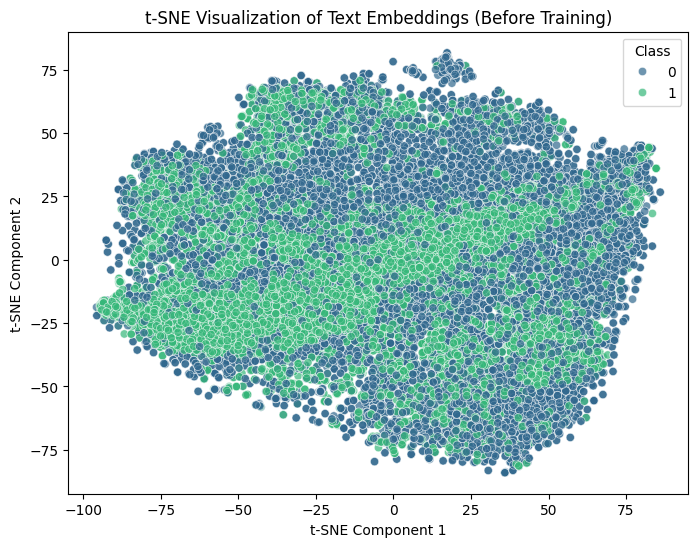

In [ ]:
# Reduce dimensions using t-SNE (Before training and after applying SMOTE)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette="viridis", alpha=0.7)
plt.title("t-SNE Visualization of Text Embeddings (Before Training)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Class")
plt.show()

In [ ]:
learning_rate = 1e-3
num_epochs = 12
loss_function =  nn.BCEWithLogitsLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1s = []

with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as pbar:
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)

        end_time = time.time()
        epoch_duration = end_time - start_time

        pbar.set_description(
            f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
            f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F1: {val_f1:.2%}, Time: {epoch_duration / 60:.2f} min"
        )
        pbar.update(1)

Epoch 12/12 - Train Loss: 0.0782, Val Loss: 0.3544, Train Acc: 97.32%, Val Acc: 86.77%, Val F1: 82.94%, Time: 0.80 min: 100%|██████████| 12/12 [09:35<00:00, 47.94s/epoch]


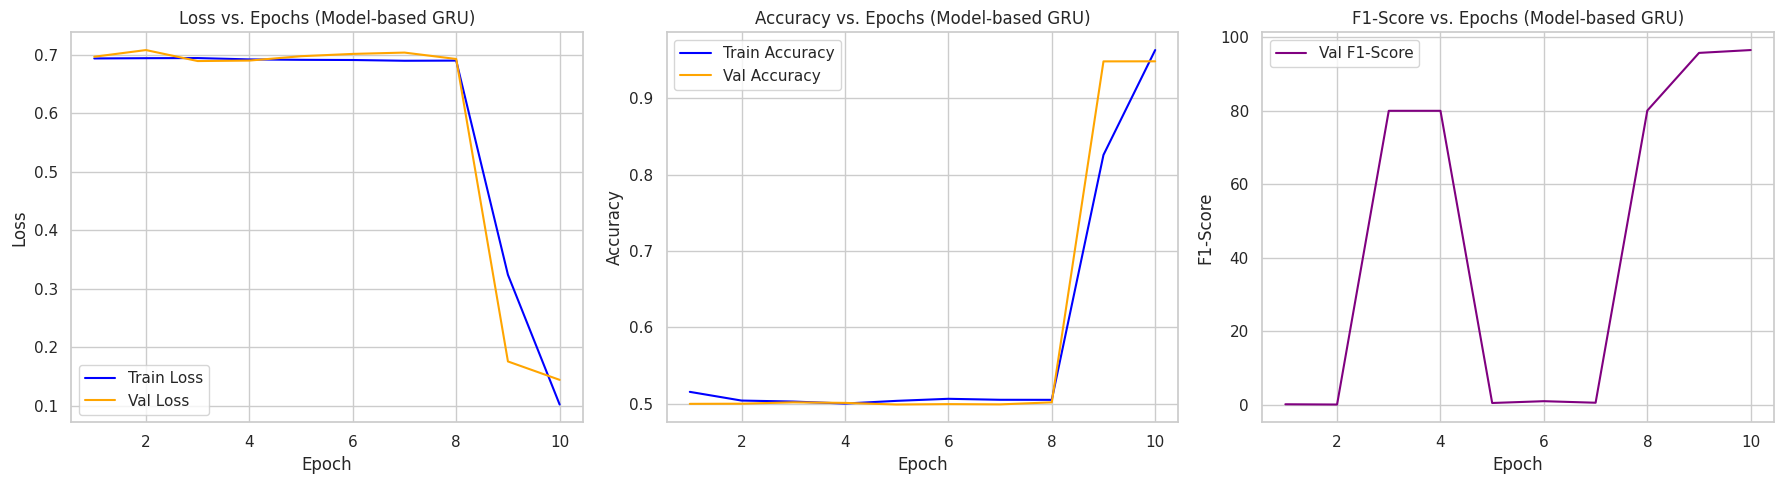

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st plot
sns.lineplot(x=range(1, len(train_losses) + 1), y=train_losses, label='Train Loss', color='blue')
sns.lineplot(x=range(1, len(val_losses) + 1), y=val_losses, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs (Model-based GRU)')
plt.legend()

plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd plot
sns.lineplot(x=range(1, len(train_accuracies) + 1), y=train_accuracies, label='Train Accuracy', color='blue')
sns.lineplot(x=range(1, len(val_accuracies) + 1), y=val_accuracies, label='Val Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs (Model-based GRU)')
plt.legend()

plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd plot
sns.lineplot(x=range(1, len(val_f1s) + 1), y=val_f1s, label='Val F1-Score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Epochs (Model-based GRU)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
hidden_states, labels = get_hidden_states(model, val_loader, device)
tsne = TSNE(n_components=2, perplexity=50, learning_rate=200)
tsne_result = tsne.fit_transform(hidden_states)

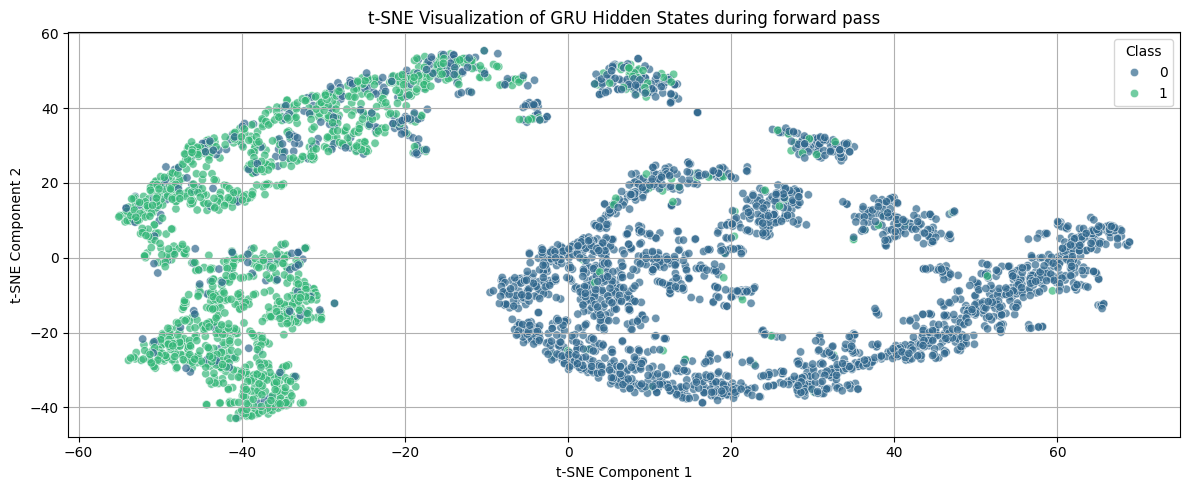

In [ ]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette="viridis", alpha=0.7)
plt.title("t-SNE Visualization of GRU Hidden States during forward pass")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Class")

plt.tight_layout()
plt.grid(True)
plt.show()

## Optimisation phase

The choice of hyperparameters for the different models was based on an analysis of the results obtained from the reports generated by Weights & Biases (WandB). These reports were used to identify the best-performing configurations in terms of accuracy, F1-score and training stability

I.1.1 Optimizer selection

In [ ]:
num_epochs = 20
learning_rate = 1e-3
loss_function = nn.BCEWithLogitsLoss()

optimizers = {
    'Adam': optim.Adam,
    'RMSprop': optim.RMSprop,
    'AdamW': optim.AdamW,
}

for optimizer_name, optimizer_class in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    model = LSTM_Model(
        vocab_size=VOCAB_SIZE,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=350,
        num_layers=1,
        dropout_prob=0.3,
        embedding_weights=embedding_matrix,
        freeze_embeddings=False
    ).to(device)

    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project='Binary_Class_Optimizer_Comparison_lstm_SMOTE', name=f"{optimizer_name}_run", config={
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'optimizer': optimizer_name,
        'model': 'CNN_LSTM_Model',
        'embedding_dim': 128,
        'hidden_dim': 167,
        'dropout_prob': 0.5
    })

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    # Progress bar for training
    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"Optimizer: {optimizer_name} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: Adam


train_acc,▁▁▁▁▁▁▁▁▇█
train_loss,████████▃▁
val_acc,▁▁▁▁▁▁▁▆██
val_f1,▇▇▁▁▂▇▁▇██
val_loss,▇▇███▇█▇▁▁
train_acc,0.97122
train_loss,0.08195
val_acc,0.94779
val_f1,96.46314
val_loss,0.12782


LSTM_Model(
  (embedding): Embedding(40002, 300)
  (lstm): LSTM(300, 350, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=350, out_features=1, bias=True)
)
Total trainable parameters: 12913751


Optimizer: Adam | Epoch 20/20 - Train Loss: 0.0220, Val Loss: 0.2770, Train ACC: 98.84%, Val ACC: 93.16%, Time: 0.89 min: 100%|██████████| 20/20 [19:13<00:00, 57.69s/epoch]


train_acc,▁▁▁▁▁▅██████████████
train_loss,█████▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁███████████████
val_f1,▇▇▁▇▇███████████████
val_loss,█████▁▁▁▂▁▂▂▂▃▃▂▃▃▄▃
train_acc,0.98844
train_loss,0.02202
val_acc,0.9316
val_f1,95.06742
val_loss,0.27701



🔹 Training with optimizer: RMSprop


LSTM_Model(
  (embedding): Embedding(40002, 300)
  (lstm): LSTM(300, 350, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=350, out_features=1, bias=True)
)
Total trainable parameters: 12913751


Optimizer: RMSprop | Epoch 20/20 - Train Loss: 0.0193, Val Loss: 0.3334, Train ACC: 98.96%, Val ACC: 93.42%, Time: 0.87 min: 100%|██████████| 20/20 [17:25<00:00, 52.27s/epoch]


train_acc,▁▁▁▁▂▆██████████████
train_loss,█████▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▃▇██████████████
val_f1,▁▇▇▇▇███████████████
val_loss,████▇▂▁▁▁▁▂▁▂▂▃▃▃▃▃▃
train_acc,0.98958
train_loss,0.01928
val_acc,0.93415
val_f1,96
val_loss,0.33343



🔹 Training with optimizer: AdamW


LSTM_Model(
  (embedding): Embedding(40002, 300)
  (lstm): LSTM(300, 350, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=350, out_features=1, bias=True)
)
Total trainable parameters: 12913751


Optimizer: AdamW | Epoch 20/20 - Train Loss: 0.0260, Val Loss: 0.2879, Train ACC: 98.81%, Val ACC: 93.91%, Time: 0.91 min: 100%|██████████| 20/20 [18:03<00:00, 54.15s/epoch]


train_acc,▁▁▁▁▁▁▁▅████████████
train_loss,███████▄▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁█████████████
val_f1,▁▇▁▇▁▁▇█████████████
val_loss,██████▇▁▁▁▁▁▁▁▂▂▂▁▂▃
train_acc,0.98814
train_loss,0.02601
val_acc,0.93915
val_f1,95.88173
val_loss,0.28793


---
RMSprop is selected as optimizer.

I.1.2 Learning rate value selection

In [ ]:
learning_rates = [8e-4, 1e-3, 7e-4]

for lr in learning_rates:
    print(f"\n🔹 Training with RMSprop and learning rate: {lr}")

    model = LSTM_Model(
        vocab_size=VOCAB_SIZE,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=350,
        num_layers=1,
        dropout_prob=0.3,
        embedding_weights=embedding_matrix,
        freeze_embeddings=False
    ).to(device)

    optimizer = optim.RMSprop(model.parameters(), lr=lr)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project='Binary_Class_learning_rate_tuning_cnn_lstm_SMOTE', name=f"RMSprop_lr_{lr}", config={
        'learning_rate': lr,
        'num_epochs': num_epochs,
        'optimizer': 'RMSprop',
        'model': 'LSTM_CNN_Model',
        'embedding_dim': 250,
        'hidden_dim': 167,
        'dropout_prob': 0.5
    })

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []
    with tqdm(total=num_epochs, desc=f"LR: {lr}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"LR: {lr} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACSA: {train_acc:.2%}, Val ACSA: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1
            })

    wandb.finish()


🔹 Training with RMSprop and learning rate: 0.0008


LR: 0.0008 | Epoch 20/20 - Train Loss: 0.0179, Val Loss: 0.3569, Train ACSA: 99.03%, Val ACSA: 93.56%, Time: 0.87 min: 100%|██████████| 20/20 [17:21<00:00, 52.10s/epoch]


train_acc,▁▁▁▁▁▁▆█████████████
train_loss,██████▃▂▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁██████████████
val_f1,▁▁▇▇▁▁██████████████
val_loss,██████▁▁▁▁▂▂▃▂▃▃▃▄▄▄
train_acc,0.99026
train_loss,0.01793
val_acc,0.93559
val_f1,95.93013
val_loss,0.3569



🔹 Training with RMSprop and learning rate: 0.001


LR: 0.001 | Epoch 20/20 - Train Loss: 0.0193, Val Loss: 0.4892, Train ACSA: 98.88%, Val ACSA: 92.60%, Time: 0.87 min: 100%|██████████| 20/20 [17:18<00:00, 51.92s/epoch]


train_acc,▁▁▁▁▁▁▃█████████████
train_loss,██████▇▂▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁██████████████
val_f1,▁▇▇▇▁▇██████████████
val_loss,██████▁▁▁▁▂▂▂▂▃▃▃▄▅▅
train_acc,0.98882
train_loss,0.01931
val_acc,0.92601
val_f1,95.73476
val_loss,0.48924



🔹 Training with RMSprop and learning rate: 0.0007


LR: 0.0007 | Epoch 20/20 - Train Loss: 0.0267, Val Loss: 0.2746, Train ACSA: 98.75%, Val ACSA: 93.18%, Time: 0.87 min: 100%|██████████| 20/20 [17:14<00:00, 51.73s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▇████████
train_loss,███████████▃▂▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▆█████████
val_f1,▇▇▁▁▇▁▁▇▁▁▇█████████
val_loss,█▇████████▅▁▁▁▁▂▂▂▃▃
train_acc,0.98754
train_loss,0.02675
val_acc,0.93184
val_f1,96.01801
val_loss,0.27456


---
We pursue with $10^{-3}$  as learning rate value.

I.1.3 Embedding dimension value selection

In [18]:
embedding_dims = [100, 250, 320]
learning_rate = 1e-3
num_epochs = 15
loss_function =  nn.BCEWithLogitsLoss()

for embedding_dim in embedding_dims:
    print(f"\n🔹 Training with embedding_dim: {embedding_dim}\n")
    run_name = f"CNN_LSTM_Embedding_{embedding_dim}"

    model = LSTM_Model(
        vocab_size=VOCAB_SIZE,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=350,
        num_layers=1,
        dropout_prob=0.3,
        embedding_weights=embedding_matrix,
        freeze_embeddings=False
    ).to(device)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Binary_Class_CNN_LSTM_Embedding_Tuning_SMOTE",
        name=run_name,
        config={
            "embedding_dim": embedding_dim,
            "learning_rate": learning_rate,
            "epochs": num_epochs,
            "hidden_dim": 167,
            "dropout": 0.5,
            "optimizer": "AdamW"
        }
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    with tqdm(total=num_epochs, desc=f"Training with Embedding={embedding_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with embedding_dim: 100



<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 15/15 - Train Loss: 0.1587, Val Loss: 0.3166, Train Acc: 95.12%, Val Acc: 90.52%, Val F-1: 86.17%,, Time: 0.78 min: 100%|██████████| 15/15 [11:57<00:00, 47.82s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▆▇████
train_loss,█████████▅▃▂▂▁▁
val_acc,▁▁▁▁▁▁▁▁▄▇█████
val_f1,▁▅▁▅▅▅▁▅▆▇█████
val_loss,▇█▇███▇█▇▃▁▁▁▁▁
train_acc,0.9512
train_loss,0.1587
val_acc,0.90521
val_f1,0.86166
val_loss,0.31655



🔹 Training with embedding_dim: 250



Epoch 15/15 - Train Loss: 0.6887, Val Loss: 0.6893, Train Acc: 50.55%, Val Acc: 49.93%, Val F-1: 0.42%,, Time: 0.76 min: 100%|██████████| 15/15 [11:34<00:00, 46.30s/epoch]


train_acc,▂▄▄▄█▃▁▆▅▇▄▅▂▂▆
train_loss,▆█▅▃▂▂▂▃▂▁▁▁▁▂▁
val_acc,▄▂▁▆▆▂▂▆▂▇▆▂██▄
val_f1,▁▁▁██▁▁█▁██▁██▁
val_loss,▃▁▄▆█▄▃▅▄▆▅▂▅▅▃
train_acc,0.50548
train_loss,0.68873
val_acc,0.49934
val_f1,0.0042
val_loss,0.68927



🔹 Training with embedding_dim: 320



Epoch 15/15 - Train Loss: 0.1394, Val Loss: 0.3125, Train Acc: 95.46%, Val Acc: 90.36%, Val F-1: 86.60%,, Time: 0.78 min: 100%|██████████| 15/15 [11:43<00:00, 46.87s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▆████
train_loss,██████████▄▂▂▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁█████
val_f1,▅▁▅▅▁▁▅▁▁▁█████
val_loss,██████████▁▁▁▁▁
train_acc,0.95463
train_loss,0.13939
val_acc,0.90361
val_f1,0.86595
val_loss,0.31247


---
Embedding dimenesion value is set to 300.

I.1.4 Depth value selection

In [19]:
depth_values = [1, 2, 3]
num_epochs = 15
learning_rate = 1e-3
loss_function = nn.BCEWithLogitsLoss()

for num_layers in depth_values:
    print(f"\n🔹 Training with GRU Depth (num_layers): {num_layers}\n")

    run_name = f"CNN_LSTM_Depth_{num_layers}"
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Binary-Class-CNN-LSTM-Depth-Tuning_SMOTE",
        name=run_name,
        config={
            "num_layers": num_layers,
            "learning_rate": learning_rate,
            "hidden_dim":167,
            "dropout":0.5,
            "optimizer": "AdamW"
        }
    )

    model = LSTM_Model(
        vocab_size=VOCAB_SIZE,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=350,
        num_layers=num_layers,
        dropout_prob=0.3,
        embedding_weights=embedding_matrix,
        freeze_embeddings=False
    ).to(device)

    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Training with CNN-LSTM Depth={num_layers}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with GRU Depth (num_layers): 1



Epoch 15/15 - Train Loss: 0.2301, Val Loss: 0.2666, Train Acc: 92.82%, Val Acc: 90.57%, Val F-1: 87.01%,, Time: 0.78 min: 100%|██████████| 15/15 [11:44<00:00, 46.93s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▃██
train_loss,████████████▇▂▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▇██
val_f1,▁▁▅▁▅▁▁▅▅▅▁▁███
val_loss,█▇██████████▃▂▁
train_acc,0.92823
train_loss,0.23013
val_acc,0.9057
val_f1,0.87009
val_loss,0.26663



🔹 Training with GRU Depth (num_layers): 2



Epoch 15/15 - Train Loss: 0.1002, Val Loss: 0.2705, Train Acc: 96.37%, Val Acc: 89.79%, Val F-1: 86.44%,, Time: 1.46 min: 100%|██████████| 15/15 [21:52<00:00, 87.49s/epoch]


train_acc,▁▁▁▁▁▁▁▁▃▆▇▇███
train_loss,████████▇▅▃▃▂▁▁
val_acc,▁▁▁▁▁▁▁▁▄▇███▇█
val_f1,▁▁▁▅▁▅▅▅▆████▇█
val_loss,████████▇▂▂▁▁▁▁
train_acc,0.96375
train_loss,0.1002
val_acc,0.89787
val_f1,0.86438
val_loss,0.27053



🔹 Training with GRU Depth (num_layers): 3



Epoch 15/15 - Train Loss: 0.6933, Val Loss: 0.6926, Train Acc: 49.27%, Val Acc: 50.00%, Val F-1: 0.00%,, Time: 2.13 min: 100%|██████████| 15/15 [31:52<00:00, 127.50s/epoch]


train_acc,▃▅▇▇▅▇██▃▄▃▁▃▄▁
train_loss,▅█▄▃▂▂▁▁▂▂▂▂▂▂▂
val_acc,█▄▂▁▂▁▁████████
val_f1,█▄▄▄▄▄▅█▁██▁▁█▁
val_loss,▄▁▃▄▃▄▄▃▃█▄▃▃▄▃
train_acc,0.49273
train_loss,0.69333
val_acc,0.5
val_f1,0
val_loss,0.69261


---
1 is depth value selected.

I.1.5 Batch size value selection

In [20]:
batch_sizes = [8, 16, 64]
embedding_dim = 300

for batch_size in batch_sizes:
    print(f"\n🔹 Training with batch size: {batch_size}")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

    model = LSTM_Model(
        vocab_size=VOCAB_SIZE,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=350,
        num_layers=1,
        dropout_prob=0.3,
        embedding_weights=embedding_matrix,
        freeze_embeddings=False
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Binary-Class-batch_size_comparison_lstm_SMOTE",
        name=f"LSTM_Batch_{batch_size}",
        config={
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "num_epochs": num_epochs,
            "optimizer": "Adam",
            "hidden_dim": 167,
            "dropout_prob": 0.5
        }
    )

    print(model)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    with tqdm(total=num_epochs, desc=f"Training with Embedding={embedding_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with batch size: 8


LSTM_Model(
  (embedding): Embedding(40002, 300)
  (lstm): LSTM(300, 350, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=350, out_features=1, bias=True)
)
Total trainable parameters: 12913751


Epoch 15/15 - Train Loss: 0.2136, Val Loss: 0.3109, Train Acc: 93.72%, Val Acc: 89.98%, Val F-1: 85.66%,, Time: 1.27 min: 100%|██████████| 15/15 [18:56<00:00, 75.74s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▂▇██
train_loss,███████████▇▃▂▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁████
val_f1,▁▅▅▅▁▅▁▁▁▁▁████
val_loss,███████████▃▁▁▁
train_acc,0.93718
train_loss,0.21361
val_acc,0.89984
val_f1,0.85659
val_loss,0.31089



🔹 Training with batch size: 16


LSTM_Model(
  (embedding): Embedding(40002, 300)
  (lstm): LSTM(300, 350, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=350, out_features=1, bias=True)
)
Total trainable parameters: 12913751


Epoch 15/15 - Train Loss: 0.1687, Val Loss: 0.2556, Train Acc: 94.34%, Val Acc: 91.23%, Val F-1: 87.30%,, Time: 0.79 min: 100%|██████████| 15/15 [11:40<00:00, 46.73s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▆▇██
train_loss,███████████▅▃▂▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▇▇██
val_f1,▁▅▅▅▁▅▅▁▁▁▁▇███
val_loss,▇██████████▃▂▁▁
train_acc,0.94344
train_loss,0.16869
val_acc,0.91227
val_f1,0.87299
val_loss,0.25563



🔹 Training with batch size: 64


LSTM_Model(
  (embedding): Embedding(40002, 300)
  (lstm): LSTM(300, 350, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=350, out_features=1, bias=True)
)
Total trainable parameters: 12913751


Epoch 15/15 - Train Loss: 0.6890, Val Loss: 0.6891, Train Acc: 50.58%, Val Acc: 49.96%, Val F-1: 0.84%,, Time: 0.47 min: 100%|██████████| 15/15 [07:00<00:00, 28.03s/epoch]


train_acc,▃▆▃▇▂▆▇▃▅▄▁▁▄▅█
train_loss,█▅▇▅▄▄▂▂▁▁▁▂▄▁▁
val_acc,▅▃▁▁▃▇▃▅▅▄▅▄▃█▄
val_f1,▁▁▁▁▁█▁▁▁▁▁▁▁█▁
val_loss,▁▃▄▂▃█▂▃▄▁▄▄▃▅▃
train_acc,0.50576
train_loss,0.68896
val_acc,0.49964
val_f1,0.00837
val_loss,0.68914


---
## I.2 **SMOTE - GRU - Glove**

## Validation phase

In [21]:
model = GRU_Model(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=350,
    num_layers=1,
    dropout_prob=0.3,
    embedding_weights=embedding_matrix,
    freeze_embeddings=False
).to(device)

print(model)
num_params = count_parameters(model)
print()
print(f"Total trainable parameters: {num_params}")

GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=350, out_features=1, bias=True)
)

Total trainable parameters: 12685551


In [22]:
model.eval()
embeddings = []
labels = []

with torch.no_grad():
    for inputs, targets, _ in train_loader:
        inputs = inputs.to(device)
        embedded = model.embedding(inputs)
        embeddings.append(embedded.mean(dim=1).cpu().numpy())
        labels.extend(targets.cpu().numpy())

# Convert lists to numpy arrays
embeddings = np.vstack(embeddings)
labels = np.array(labels)

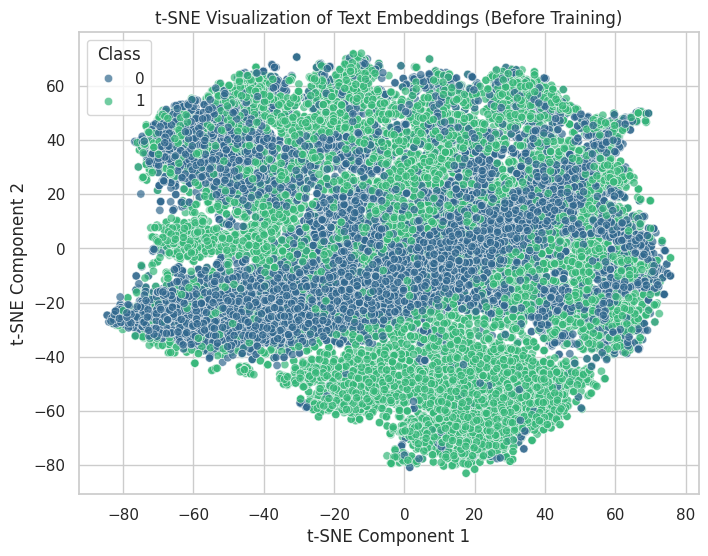

In [ ]:
# Reduce dimensions using t-SNE (Before training and after applying SMOTE)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette="viridis", alpha=0.7)
plt.title("t-SNE Visualization of Text Embeddings (Before Training)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Class")
plt.show()

In [26]:
learning_rate = 1e-3
num_epochs = 15
loss_function =  nn.BCEWithLogitsLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-5)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1s = []

with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as pbar:
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)

        end_time = time.time()
        epoch_duration = end_time - start_time

        pbar.set_description(
            f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
            f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F1: {val_f1:.2%}, Time: {epoch_duration / 60:.2f} min"
        )
        pbar.update(1)

Epoch 15/15 - Train Loss: 0.0973, Val Loss: 0.3602, Train Acc: 96.48%, Val Acc: 89.58%, Val F1: 85.06%, Time: 0.36 min: 100%|██████████| 15/15 [05:22<00:00, 21.51s/epoch]


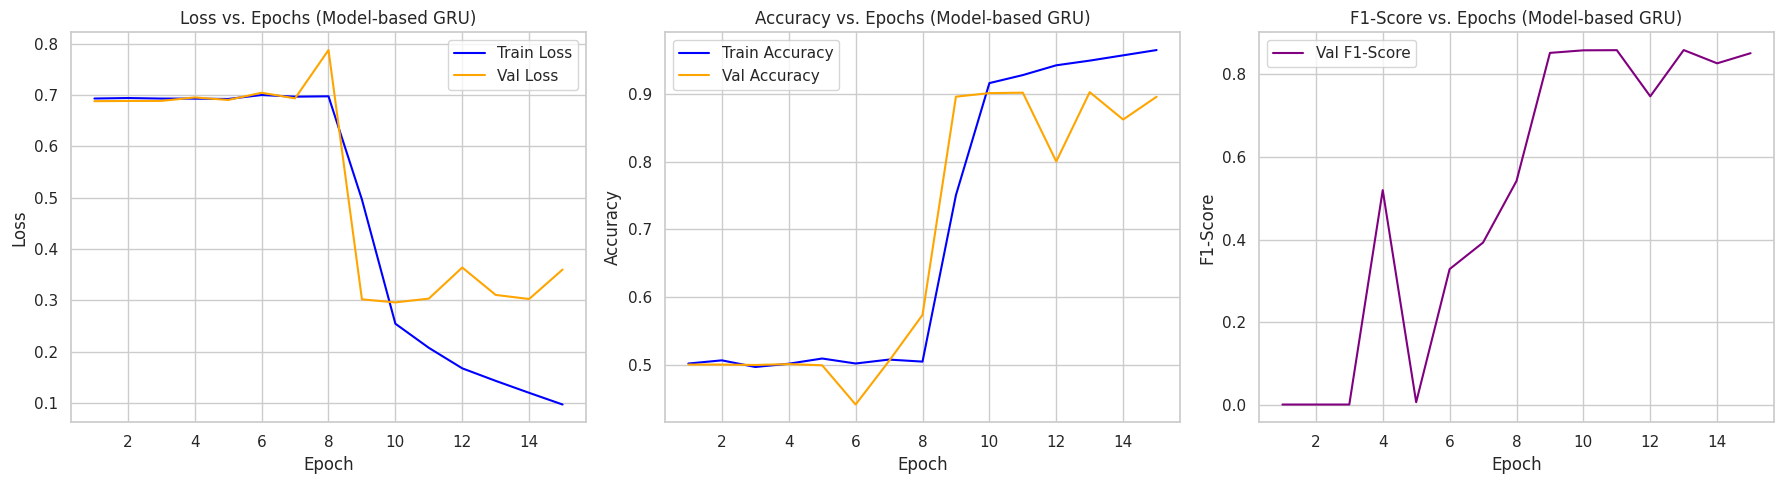

In [27]:
sns.set(style="whitegrid")

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st plot
sns.lineplot(x=range(1, len(train_losses) + 1), y=train_losses, label='Train Loss', color='blue')
sns.lineplot(x=range(1, len(val_losses) + 1), y=val_losses, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs (Model-based GRU)')
plt.legend()

plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd plot
sns.lineplot(x=range(1, len(train_accuracies) + 1), y=train_accuracies, label='Train Accuracy', color='blue')
sns.lineplot(x=range(1, len(val_accuracies) + 1), y=val_accuracies, label='Val Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs (Model-based GRU)')
plt.legend()

plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd plot
sns.lineplot(x=range(1, len(val_f1s) + 1), y=val_f1s, label='Val F1-Score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Epochs (Model-based GRU)')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
hidden_states, labels = get_hidden_states(model, val_loader, device)
tsne = TSNE(n_components=2, perplexity=50, learning_rate=200)
tsne_result = tsne.fit_transform(hidden_states)

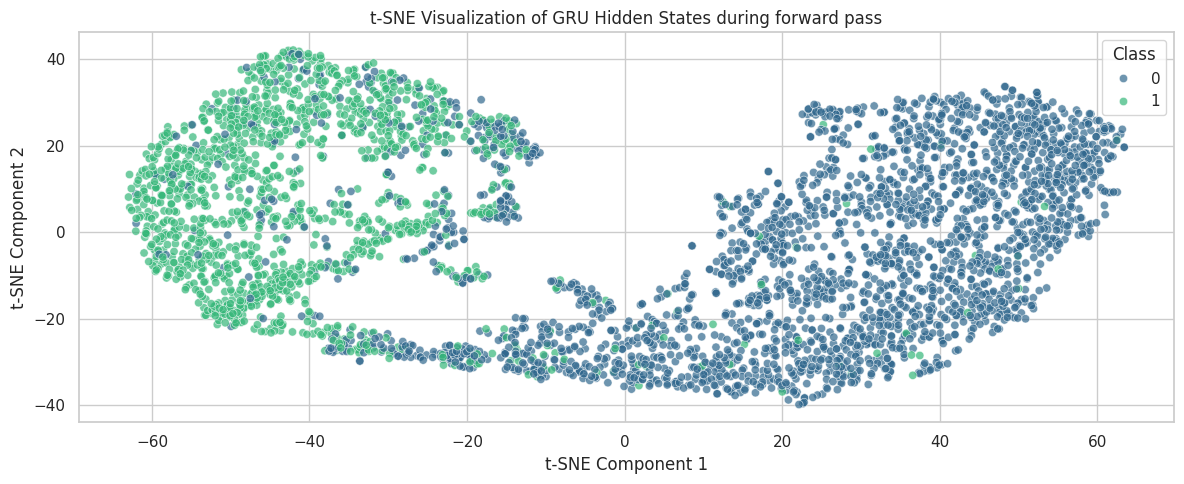

In [29]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette="viridis", alpha=0.7)
plt.title("t-SNE Visualization of GRU Hidden States during forward pass")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Class")

plt.tight_layout()
plt.grid(True)
plt.show()

## Optimization phase



The choice of hyperparameters for the different models was based on an analysis of the results obtained from the reports generated by Weights & Biases (WandB). These reports were used to identify the best-performing configurations in terms of accuracy, F1-score and training stability

I.2.1 Optimizer selection

In [31]:
num_epochs = 15
learning_rate = 1e-3
loss_function =  nn.BCEWithLogitsLoss()

optimizers = {
    'RMSprop': optim.RMSprop,
    'Adam': optim.Adam,
    'AdamW': optim.AdamW,
}

for optimizer_name, optimizer_class in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=350, num_layers=1,dropout_prob=0.4, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project='Binary_Class_Optimizer_Comparison_gru_glove300d_SMOTE', name=f"{optimizer_name}_run", config={
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'optimizer': optimizer_name,
        'model': 'GRU_Model',
        'embedding_dim': 300,
        'hidden_dim': 350,
        'dropout_prob': 0.5
    })

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    # Progress bar for training
    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"Optimizer: {optimizer_name} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: RMSprop


train_acc,▁
train_loss,▁
val_acc,▁
val_f1,▁
val_loss,▁
train_acc,0.50184
train_loss,0.6936
val_acc,0.49773
val_f1,0.00831
val_loss,0.69214


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=350, out_features=1, bias=True)
)
Total trainable parameters: 12685551


Optimizer: RMSprop | Epoch 15/15 - Train Loss: 0.0357, Val Loss: 0.4670, Train ACC: 98.50%, Val ACC: 88.63%, Time: 0.36 min: 100%|██████████| 15/15 [05:26<00:00, 21.76s/epoch]


train_acc,▁▁▁▁▁▁▁▃▇▇█████
train_loss,███████▇▃▂▂▁▁▁▁
val_acc,▁▁▁▁▁▁▁█████▇▇█
val_f1,▁▅▁▁▅▁▁████████
val_loss,███████▂▁▁▃▂▃▂▄
train_acc,0.98504
train_loss,0.03571
val_acc,0.88633
val_f1,0.8427
val_loss,0.46702



🔹 Training with optimizer: Adam


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=350, out_features=1, bias=True)
)
Total trainable parameters: 12685551


Optimizer: Adam | Epoch 15/15 - Train Loss: 0.0260, Val Loss: 0.4637, Train ACC: 98.74%, Val ACC: 88.31%, Time: 0.36 min: 100%|██████████| 15/15 [05:25<00:00, 21.73s/epoch]


train_acc,▁▁▂▇▇██████████
train_loss,██▇▃▃▂▁▁▁▁▁▁▁▁▁
val_acc,▁▁███████▇▇▇▇██
val_f1,▁▁▇████▇▇▇▇▇▇▇▇
val_loss,██▃▁▁▁▃▃▃▄▄▄▄▅▄
train_acc,0.98737
train_loss,0.02604
val_acc,0.88306
val_f1,0.84591
val_loss,0.46371



🔹 Training with optimizer: AdamW


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=350, out_features=1, bias=True)
)
Total trainable parameters: 12685551


Optimizer: AdamW | Epoch 15/15 - Train Loss: 0.6894, Val Loss: 0.6999, Train ACC: 50.00%, Val ACC: 50.29%, Time: 0.37 min: 100%|██████████| 15/15 [05:27<00:00, 21.84s/epoch]


train_acc,▃▃▁▆▅▇▆▄▆███▆▁▃
train_loss,█▆▅▂▁▂▁▁▁▁▁▁▁▁▁
val_acc,▄▁▃▂▇▆▂▁▃▂▂▃▃▄█
val_f1,█▁▁▁▂█▁▁▁▁▁▁▁▁█
val_loss,▆▃▅▃▆█▄▃▁▄▂▂▅▅▇
train_acc,0.49996
train_loss,0.68938
val_acc,0.50292
val_f1,0.52083
val_loss,0.69989


---

I.2.2 Learning rate value selection

In [32]:
learning_rates = [9-4, 4e-3, 1e-3]

for lr in learning_rates:
    print(f"\n🔹 Training with RMSprop and learning rate: {lr}")

    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=350, num_layers=1,dropout_prob=0.4, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project='Binary_Class_learning_rate_tuning_gru_glove300d_SMOTE', name=f"RMSprop_lr_{lr}", config={
        'learning_rate': lr,
        'num_epochs': num_epochs,
        'optimizer': 'RMPprop',
        'model': 'GRU_Model',
        'embedding_dim': 300,
        'hidden_dim': 350,
        'dropout_prob': 0.5
    })

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []
    with tqdm(total=num_epochs, desc=f"LR: {lr}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"LR: {lr} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACSA: {train_acc:.2%}, Val ACSA: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1
            })

    wandb.finish()


🔹 Training with RMSprop and learning rate: 5


LR: 5 | Epoch 15/15 - Train Loss: nan, Val Loss: nan, Train ACSA: 50.00%, Val ACSA: 50.00%, Time: 0.32 min: 100%|██████████| 15/15 [04:46<00:00, 19.11s/epoch]


train_acc,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.5
train_loss,nan
val_acc,0.5
val_f1,0
val_loss,nan



🔹 Training with RMSprop and learning rate: 0.004


LR: 0.004 | Epoch 15/15 - Train Loss: nan, Val Loss: nan, Train ACSA: 50.00%, Val ACSA: 50.00%, Time: 0.32 min: 100%|██████████| 15/15 [04:46<00:00, 19.13s/epoch]


train_acc,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.5
train_loss,nan
val_acc,0.5
val_f1,0
val_loss,nan



🔹 Training with RMSprop and learning rate: 0.001


LR: 0.001 | Epoch 15/15 - Train Loss: 0.0276, Val Loss: 0.5608, Train ACSA: 98.72%, Val ACSA: 87.33%, Time: 0.36 min: 100%|██████████| 15/15 [05:26<00:00, 21.75s/epoch]


train_acc,▁▁▄▇▇██████████
train_loss,██▆▃▃▂▂▁▁▁▁▁▁▁▁
val_acc,▁▁███████▇█▇█▇▇
val_f1,▅▁█████████████
val_loss,██▂▁▁▂▂▂▃▃▃▄▄▄▆
train_acc,0.98725
train_loss,0.02756
val_acc,0.87334
val_f1,0.83299
val_loss,0.56084


---
RMSprop is selected as optimizer.

I.2.3 Hidden dimension value selection

In [33]:
hidden_dims = [100, 250, 400]
learning_rate = 1e-3

for hidden_dim in hidden_dims:
    print(f"\n🔹 Training with hidden_dim: {hidden_dim}\n")
    run_name = f"GRU_Hidden_{hidden_dim}"

    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=hidden_dim, num_layers=1,dropout_prob=0.4, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Binary_Class_GRU-Hidden-Tuning-glove300d_SMOTE",
        name=run_name,
        config={
            "embedding_dim": EMBEDDING_DIM,
            "learning_rate": learning_rate,
            "epochs": num_epochs,
            "hidden_dim": 350,
            "dropout": 0.4,
            "optimizer": "RMSprop"
        }
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    with tqdm(total=num_epochs, desc=f"Training with Hidden={hidden_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with hidden_dim: 100



Epoch 15/15 - Train Loss: 0.0873, Val Loss: 0.3046, Train Acc: 96.95%, Val Acc: 84.16%, Val F-1: 80.42%,, Time: 0.09 min: 100%|██████████| 15/15 [01:22<00:00,  5.51s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▃▇▇██
train_loss,██████████▇▄▂▂▁
val_acc,▁▁▁▁▁▁▁▁▁▂██▇▇▇
val_f1,▁▅▁▁▁▅▅▅▁▄████▇
val_loss,██████████▂▁▁▁▁
train_acc,0.96951
train_loss,0.08731
val_acc,0.84163
val_f1,0.80422
val_loss,0.30463



🔹 Training with hidden_dim: 250



Epoch 15/15 - Train Loss: 0.0185, Val Loss: 0.5932, Train Acc: 98.87%, Val Acc: 89.09%, Val F-1: 85.63%,, Time: 0.24 min: 100%|██████████| 15/15 [03:40<00:00, 14.68s/epoch]


train_acc,▁▁▆▇▇██████████
train_loss,██▅▃▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▃█████▇██▇██▇█
val_f1,▁▅████████▇████
val_loss,██▁▁▁▁▁▂▅▄▅▅▇▆▆
train_acc,0.98872
train_loss,0.01851
val_acc,0.89093
val_f1,0.85635
val_loss,0.59316



🔹 Training with hidden_dim: 400



Epoch 15/15 - Train Loss: 0.0517, Val Loss: 0.3454, Train Acc: 98.08%, Val Acc: 87.37%, Val F-1: 84.05%,, Time: 0.41 min: 100%|██████████| 15/15 [06:03<00:00, 24.22s/epoch]


train_acc,▁▁▁▁▁▁▁▁▂▇▇████
train_loss,████████▇▃▂▂▁▁▁
val_acc,▁▂▁▁▁▁▁▁███▇██▇
val_f1,▅▄▄▂▁▄▅▅███▇███
val_loss,███▇▇███▂▂▁▂▁▂▂
train_acc,0.98079
train_loss,0.05172
val_acc,0.87366
val_f1,0.84045
val_loss,0.34539


---
Hidden dimension value is set to 250.

I.2.4 Depth value selection

In [34]:
depth_values = [1, 2, 3]

for num_layers in depth_values:
    print(f"\n🔹 Training with GRU Depth (num_layers): {num_layers}\n")
    run_name = f"GRU_Depth_{num_layers}"
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Binary-Class-GRU-Depth-Tuning-glove300d_SMOTE",
        name=run_name,
        config={
            "num_layers": num_layers,
            "learning_rate": learning_rate,
            "hidden_dim":350,
            "dropout":0.4,
            "optimizer": "RMSprop"
        }
    )
    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=350, num_layers=num_layers,dropout_prob=0.4, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Training with GRU Depth={num_layers}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with GRU Depth (num_layers): 1



Epoch 15/15 - Train Loss: 0.3274, Val Loss: 0.3221, Train Acc: 88.82%, Val Acc: 89.02%, Val F-1: 84.65%,, Time: 0.36 min: 100%|██████████| 15/15 [05:22<00:00, 21.51s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▆█
train_loss,█████████████▄▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁██
val_f1,▁▅▁▁▅▅▅▄▅▄▄▂▄██
val_loss,▇▇▇▇▇██▇█▇▇▇▇▃▁
train_acc,0.88822
train_loss,0.32744
val_acc,0.89016
val_f1,0.84653
val_loss,0.32211



🔹 Training with GRU Depth (num_layers): 2



Epoch 15/15 - Train Loss: 0.0207, Val Loss: 0.5174, Train Acc: 98.79%, Val Acc: 89.49%, Val F-1: 85.69%,, Time: 0.72 min: 100%|██████████| 15/15 [10:45<00:00, 43.06s/epoch]


train_acc,▁▆▇▇▇██████████
train_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▇███▆▁▆▆▄▆▆▆▂▆▆
val_f1,▇██▇▆▁▆▆▃▆▆▆▂▆▆
val_loss,▁▁▁▁▂▂▃▃█▄▄▄▄▄▅
train_acc,0.9879
train_loss,0.02067
val_acc,0.89487
val_f1,0.85695
val_loss,0.5174



🔹 Training with GRU Depth (num_layers): 3



Epoch 15/15 - Train Loss: 0.0282, Val Loss: 0.5544, Train Acc: 98.75%, Val Acc: 85.05%, Val F-1: 81.26%,, Time: 1.11 min: 100%|██████████| 15/15 [16:41<00:00, 66.75s/epoch]


train_acc,▁▅▆▆▇▇▇▇███████
train_loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁
val_acc,▃██▇▇█▇▅▄▁▇▄▃▅▂
val_f1,▁█▇▅██▆▅▄▁▇▄▄▅▂
val_loss,▅▁▂▂▁▃▄▃▃▄█▅▆▇█
train_acc,0.98753
train_loss,0.02819
val_acc,0.85048
val_f1,0.81264
val_loss,0.55443


---
Depth value is set to 1.

I.2.5 Batch size value selection

In [ ]:
batch_sizes = [8, 16, 64]

for batch_size in batch_sizes:
    print(f"\n🔹 Training with batch size: {batch_size}")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=250, num_layers=1,dropout_prob=0.3, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Binary-Class-batch_size_comparison_gru_glove300d_SMOTE",
        name=f"GRU_Batch_{batch_size}",
        config={
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "num_epochs": num_epochs,
            "optimizer": "RMSprop",
            "hidden_dim": 250,
            "dropout_prob": 0.4
        }
    )

    print(model)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    with tqdm(total=num_epochs, desc=f"Training with Embedding={hidden_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with batch size: 8


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 250, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=250, out_features=1, bias=True)
)
Total trainable parameters: 12414851


Epoch 13/15 - Train Loss: 0.0285, Val Loss: 0.3953, Train Acc: 98.63%, Val Acc: 87.09%, Val F-1: 83.58%,, Time: 0.98 min:  87%|████████▋ | 13/15 [12:42<01:57, 58.61s/epoch]

---
Btach size value is set to 16.

---
# II. **Weighted Training**

---

**Weighted training** involves assigning different weights to the classes in a loss function when training a model, in order to compensate for the imbalance between classes. In unbalanced datasets, where certain classes are under-represented, the aim is to make errors on minority classes more costly for the model. This allows the model to pay more attention to these under-represented classes, which generally improves its ability to predict these classes correctly. Weights are usually calculated as a function of class frequency, and these weights are incorporated into the loss function, such as CrossEntropyLoss in PyTorch. This helps to balance the impact of different classes on training, without the need to generate new data or modify the training set.

In [ ]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train_tensor.cpu().numpy())
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor[1])

In [ ]:
batch_size = 16
train_dataset = TextDataset(X_train_tensor, y_train_tensor, raw_text_data=X_train)
val_dataset = TextDataset(X_val_tensor, y_val, raw_text_data=X_val)
test_dataset = TextDataset(X_test_tensor, y_test, raw_text_data=X_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

---

## II.1 **Weighted Training - LSTM- Glove**

## Validation phase

In [ ]:
model = LSTM_Model(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=350,
    num_layers=1,
    dropout_prob=0.3,
    embedding_weights=embedding_matrix,
    freeze_embeddings=False
).to(device)

print(model)
num_params = count_parameters(model)
print()
print(f"Total trainable parameters: {num_params}")

In [ ]:
optimizer = optim.RMSprop(model.parameters(), lr=1e-3)
num_epochs = 15
loss_function = criterion
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1s = []

with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as pbar:
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)

        end_time = time.time()
        epoch_duration = end_time - start_time

        pbar.set_description(
            f"Epoch {epoch+1}/10 - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
            f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F1: {val_f1:.2%}, Time: {epoch_duration / 60:.2f} min"
        )
        pbar.update(1)

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st plot
sns.lineplot(x=range(1, len(train_losses) + 1), y=train_losses, label='Train Loss', color='blue')
sns.lineplot(x=range(1, len(val_losses) + 1), y=val_losses, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs (Model-based LSTM)')
plt.legend()

plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd plot
sns.lineplot(x=range(1, len(train_accuracies) + 1), y=train_accuracies, label='Train Accuracy', color='blue')
sns.lineplot(x=range(1, len(val_accuracies) + 1), y=val_accuracies, label='Val Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs (Model-based LSTM)')
plt.legend()

plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd plot
sns.lineplot(x=range(1, len(val_f1s) + 1), y=val_f1s, label='Val F1-Score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Epochs (Model-based LSTM)')
plt.legend()

plt.tight_layout()
plt.show()

## Optimization phase

The choice of hyperparameters for the different models was based on an analysis of the results obtained from the reports generated by Weights & Biases (WandB). These reports were used to identify the best-performing configurations in terms of accuracy, F1-score and training stability

The choice of hyperparameters for the different models was based on an analysis of the results obtained from the reports generated by Weights & Biases (WandB). These reports were used to identify the best-performing configurations in terms of accuracy, F1-score and training stability

II.1.1 Optimizer selection

In [ ]:
num_epochs = 20
learning_rate = 1e-3

optimizers = {
    'Adam': optim.Adam,
    'RMSprop': optim.RMSprop,
    'AdamW': optim.AdamW,
}

for optimizer_name, optimizer_class in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    model = LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=300, hidden_dim=200, num_layers=1, dropout_prob=0.5).to(device)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project='Binary_Class_Optimizer_Tuning_cnn_lstm_Weighted_Training', name=f"{optimizer_name}_run", config={
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'optimizer': optimizer_name,
        'model': 'CNN_LSTM_Model',
        'embedding_dim': 128,
        'hidden_dim': 167,
        'dropout_prob': 0.5
    })

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    # Progress bar for training
    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"Optimizer: {optimizer_name} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()

---
Adam optimizer is selected.

II.1.2 Learning rate value selection

In [ ]:
learning_rates = [8e-4, 1e-3, 7e-4]

for lr in learning_rates:
    print(f"\n🔹 Training with RMSprop and learning rate: {lr}")

    model = LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=300, hidden_dim=200, num_layers=1, dropout_prob=0.5).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=lr)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project='Binary_Class_learning_rate_Tuning_cnn_lstm_Weighted_Training', name=f"RMSprop_lr_{lr}", config={
        'learning_rate': lr,
        'num_epochs': num_epochs,
        'optimizer': 'RMSprop',
        'model': 'LSTM_CNN_Model',
        'embedding_dim': 250,
        'hidden_dim': 167,
        'dropout_prob': 0.5
    })

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []
    with tqdm(total=num_epochs, desc=f"LR: {lr}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"LR: {lr} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACSA: {train_acc:.2%}, Val ACSA: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1
            })

    wandb.finish()

---
Learning rate value is set to $9 \cdot 10^{-4}$.

II.1.3 Embedding dimension value selection

In [ ]:
embedding_dims = [100, 250, 320]
learning_rate = 9e-4

for embedding_dim in embedding_dims:
    print(f"\n🔹 Training with embedding_dim: {embedding_dim}\n")
    run_name = f"CNN_LSTM_Embedding_{embedding_dim}"
    model = LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=embedding_dim, hidden_dim=200, num_layers=1, dropout_prob=0.5).to(device)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Binary_Class_CNN_LSTM_Embedding_Tuning_Weighted_Training",
        name=run_name,
        config={
            "embedding_dim": embedding_dim,
            "learning_rate": learning_rate,
            "epochs": num_epochs,
            "hidden_dim": 167,
            "dropout": 0.5,
            "optimizer": "AdamW"
        }
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    with tqdm(total=num_epochs, desc=f"Training with Embedding={embedding_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()

---
Embedding dimension value is set to 250.

II.2.4 Depth value selection

In [ ]:
depth_values = [1, 2, 3]

for num_layers in depth_values:
    print(f"\n🔹 Training with CNN-LSTM Depth (num_layers): {num_layers}\n")

    run_name = f"CNN_LSTM_Depth_{num_layers}"
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Binary-Class-CNN-LSTM-Depth-Tuning_Weighted_Training",
        name=run_name,
        config={
            "num_layers": num_layers,
            "learning_rate": learning_rate,
            "hidden_dim":167,
            "dropout":0.5,
            "optimizer": "AdamW"
        }
    )
    model = LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=300, hidden_dim=167, num_layers=num_layers, dropout_prob=0.3).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Training with CNN-LSTM Depth={num_layers}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()

---
Depth value is set to 1.

II.1.5 Batch size value selection

In [ ]:
batch_sizes = [8, 16, 64]

for batch_size in batch_sizes:
    print(f"\n🔹 Training with batch size: {batch_size}")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

    model = LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=300, hidden_dim=200, num_layers=1, dropout_prob=0.5).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Binary-Class-batch_size_cnn_lstm_Tuning_Weighted_Training",
        name=f"LSTM_Batch_{batch_size}",
        config={
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "num_epochs": num_epochs,
            "optimizer": "Adam",
            "hidden_dim": 200,
            "dropout_prob": 0.5
        }
    )

    print(model)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    with tqdm(total=num_epochs, desc=f"Training with Embedding={embedding_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()

---
Batch size value is set to 16.

---

## II.2 **Weighted Training - GRU - Glove**

## Validation phase

In [ ]:
model = GRU_Model(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=280,
    num_layers=1,
    dropout_prob=0.5,
    embedding_weights=embedding_matrix,
    freeze_embeddings=False
).to(device)

print(model)
num_params = count_parameters(model)
print()
print(f"Total trainable parameters: {num_params}")

In [ ]:
learning_rate = 1e-3
num_epochs = 15
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1s = []

with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as pbar:
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)

        end_time = time.time()
        epoch_duration = end_time - start_time

        pbar.set_description(
            f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
            f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F1: {val_f1:.2%}, Time: {epoch_duration / 60:.2f} min"
        )
        pbar.update(1)

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st plot
sns.lineplot(x=range(1, len(train_losses) + 1), y=train_losses, label='Train Loss', color='blue')
sns.lineplot(x=range(1, len(val_losses) + 1), y=val_losses, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs (Model-based GRU)')
plt.legend()

plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd plot
sns.lineplot(x=range(1, len(train_accuracies) + 1), y=train_accuracies, label='Train Accuracy', color='blue')
sns.lineplot(x=range(1, len(val_accuracies) + 1), y=val_accuracies, label='Val Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs (Model-based GRU)')
plt.legend()

plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd plot
sns.lineplot(x=range(1, len(val_f1s) + 1), y=val_f1s, label='Val F1-Score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Epochs (Model-based GRU)')
plt.legend()

plt.tight_layout()
plt.show()

## Optimization phase

The choice of hyperparameters for the different models was based on an analysis of the results obtained from the reports generated by Weights & Biases (WandB). These reports were used to identify the best-performing configurations in terms of accuracy, F1-score and training stability

II.2.1 Optimizer selection

In [ ]:
num_epochs = 12
learning_rate = 1e-3

optimizers = {
    'RMSprop': optim.RMSprop,
    'Adam': optim.Adam,
    'AdamW': optim.AdamW,
}

for optimizer_name, optimizer_class in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=280, num_layers=1,dropout_prob=0.4, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project='Binary_Class_Optimizer_Comparison_gru_Weighted_Training', name=f"{optimizer_name}_run", config={
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'optimizer': optimizer_name,
        'model': 'GRU_Model',
        'embedding_dim': 300,
        'hidden_dim': 350,
        'dropout_prob': 0.5
    })

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    # Progress bar for training
    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"Optimizer: {optimizer_name} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()

---
Adam optimizer is selected as optimizer.

II.2.2 Learning rate value selection

In [ ]:
learning_rates = [2e-3, 8e-3, 4e-3]
num_epochs = 12

for lr in learning_rates:
    print(f"\n🔹 Training with RMSprop and learning rate: {lr}")

    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=280, num_layers=1,dropout_prob=0.4, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project='Binary_Class_learning_rate_tuning_gru_glove300d_Weighted_Training', name=f"RMSprop_lr_{lr}", config={
        'learning_rate': lr,
        'num_epochs': num_epochs,
        'optimizer': 'RMPprop',
        'model': 'GRU_Model',
        'embedding_dim': 300,
        'hidden_dim': 350,
        'dropout_prob': 0.5
    })

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []
    with tqdm(total=num_epochs, desc=f"LR: {lr}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"LR: {lr} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACSA: {train_acc:.2%}, Val ACSA: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1
            })

    wandb.finish()

---
Learning rate value is set to $10^{-3}$.

II.2.3 Hidden dimension value selection

In [ ]:
hidden_dims = [100, 250, 400]
learning_rate = 2e-3

for hidden_dim in hidden_dims:
    print(f"\n🔹 Training with hidden_dim: {hidden_dim}\n")
    run_name = f"GRU_Hidden_{hidden_dim}"

    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=280, num_layers=1,dropout_prob=0.4, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Binary_Class_GRU-Hidden-Tuning-gru-glove300d_Weighted_Training",
        name=run_name,
        config={
            "embedding_dim": EMBEDDING_DIM,
            "learning_rate": learning_rate,
            "epochs": num_epochs,
            "hidden_dim": 200,
            "dropout": 0.4,
            "optimizer": "RMSprop"
        }
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    with tqdm(total=num_epochs, desc=f"Training with Hidden={hidden_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with hidden_dim: 100



Epoch 7/7 - Train Loss: 2.2019, Val Loss: 2.2011, Train Acc: 11.08%, Val Acc: 11.59%, Val F-1: 2.41%,, Time: 0.68 min: 100%|██████████| 7/7 [04:57<00:00, 42.53s/epoch]


train_acc,▆█▃▁▁▁▁
train_loss,▄▁▆████
val_acc,█▆▁▁▁▁▁
val_f1,█▆▁▁▁▁▁
val_loss,▁▃█████
train_acc,0.11084
train_loss,2.20193
val_acc,0.1159
val_f1,0.02409
val_loss,2.2011



🔹 Training with hidden_dim: 250



Epoch 7/7 - Train Loss: 0.2627, Val Loss: 0.2992, Train Acc: 92.19%, Val Acc: 90.84%, Val F-1: 90.90%,, Time: 0.69 min: 100%|██████████| 7/7 [04:48<00:00, 41.28s/epoch]


train_acc,▁██████
train_loss,█▂▁▁▁▁▁
val_acc,▁▄▅█▇█▅
val_f1,▁▄▆█▇█▅
val_loss,█▄▄▃▂▁▃
train_acc,0.9219
train_loss,0.26275
val_acc,0.90842
val_f1,0.90899
val_loss,0.29917



🔹 Training with hidden_dim: 400



Epoch 7/7 - Train Loss: 2.2046, Val Loss: 2.2007, Train Acc: 11.38%, Val Acc: 11.68%, Val F-1: 2.62%,, Time: 0.68 min: 100%|██████████| 7/7 [04:47<00:00, 41.13s/epoch]


train_acc,▃█▇▃▁▁▁
train_loss,▇▁▃▆███
val_acc,██▂▂▁▂▂
val_f1,██▁▁▁▁▁
val_loss,▂▁█████
train_acc,0.11376
train_loss,2.20461
val_acc,0.11676
val_f1,0.02617
val_loss,2.20069


---
Hidden dimension value is set to 250.


II.2.4 Depth value selection

In [ ]:
depth_values = [1, 2, 3]

for num_layers in depth_values:
    print(f"\n🔹 Training with GRU Depth (num_layers): {num_layers}\n")
    run_name = f"GRU_Depth_{num_layers}"
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Binary-Class-GRU-Depth-Tuning-glove300d_Weighted_Training",
        name=run_name,
        config={
            "num_layers": num_layers,
            "learning_rate": learning_rate,
            "hidden_dim":350,
            "dropout":0.4,
            "optimizer": "RMSprop"
        }
    )
    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=280, num_layers=1,dropout_prob=0.4, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Training with GRU Depth={num_layers}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with GRU Depth (num_layers): 1



Epoch 7/7 - Train Loss: 0.2489, Val Loss: 0.2729, Train Acc: 92.50%, Val Acc: 91.41%, Val F-1: 91.46%,, Time: 0.69 min: 100%|██████████| 7/7 [04:49<00:00, 41.33s/epoch]


train_acc,▁██████
train_loss,█▁▁▁▁▁▁
val_acc,▁▅▅█▃▇█
val_f1,▁▆▅▇▃██
val_loss,█▄▃▂▄▂▁
train_acc,0.92504
train_loss,0.24888
val_acc,0.91411
val_f1,0.9146
val_loss,0.27287



🔹 Training with GRU Depth (num_layers): 2



Epoch 7/7 - Train Loss: 0.2482, Val Loss: 0.2731, Train Acc: 92.55%, Val Acc: 91.65%, Val F-1: 91.66%,, Time: 0.69 min: 100%|██████████| 7/7 [04:49<00:00, 41.31s/epoch]


train_acc,▁▇▇████
train_loss,█▂▂▁▁▁▁
val_acc,▁▃▄██▆▇
val_f1,▁▂▄█▇▆▇
val_loss,█▆▆▂▂▁▂
train_acc,0.92545
train_loss,0.24821
val_acc,0.91652
val_f1,0.91662
val_loss,0.27311



🔹 Training with GRU Depth (num_layers): 3



Epoch 7/7 - Train Loss: 0.2499, Val Loss: 0.2712, Train Acc: 92.42%, Val Acc: 91.32%, Val F-1: 91.47%,, Time: 0.69 min: 100%|██████████| 7/7 [04:48<00:00, 41.28s/epoch]


train_acc,▁██████
train_loss,█▁▁▁▁▁▁
val_acc,▁▄▆▆▇█▇
val_f1,▁▅▇▆▇██
val_loss,█▅▂▃▄▁▂
train_acc,0.92419
train_loss,0.24989
val_acc,0.91325
val_f1,0.91466
val_loss,0.27124


---
Depth value is set to 1.

II.2.5 Batch size value selection

In [ ]:
batch_sizes = [8, 16, 64]

for batch_size in batch_sizes:
    print(f"\n🔹 Training with batch size: {batch_size}")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=280, num_layers=1,dropout_prob=0.3, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Binary-Class-batch_size_comparison_gru_glove300d_Weighted_Training",
        name=f"GRU_Batch_{batch_size}",
        config={
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "num_epochs": num_epochs,
            "optimizer": "RMSprop",
            "hidden_dim": 250,
            "dropout_prob": 0.4
        }
    )

    print(model)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    with tqdm(total=num_epochs, desc=f"Training with Embedding={hidden_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with batch size: 8


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 280, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=280, out_features=9, bias=True)
)
Total trainable parameters: 12492009


Epoch 7/7 - Train Loss: 0.1158, Val Loss: 0.4329, Train Acc: 97.23%, Val Acc: 91.82%, Val F-1: 91.82%,, Time: 1.18 min: 100%|██████████| 7/7 [08:17<00:00, 71.04s/epoch]


train_acc,▁▇█████
train_loss,█▂▁▁▁▁▁
val_acc,▄▅█▅▂▁▂
val_f1,▃▅█▆▁▁▂
val_loss,▁▁▃▃▅▇█
train_acc,0.97228
train_loss,0.1158
val_acc,0.91825
val_f1,0.91816
val_loss,0.43289



🔹 Training with batch size: 16


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 280, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=280, out_features=9, bias=True)
)
Total trainable parameters: 12492009


Epoch 7/7 - Train Loss: 0.0629, Val Loss: 0.3795, Train Acc: 98.13%, Val Acc: 91.58%, Val F-1: 91.57%,, Time: 0.71 min: 100%|██████████| 7/7 [05:00<00:00, 42.94s/epoch]


train_acc,▁▇█████
train_loss,█▂▂▁▁▁▁
val_acc,▇█▅█▄▃▁
val_f1,▇█▅█▅▃▁
val_loss,▂▁▂▃▅▅█
train_acc,0.9813
train_loss,0.06293
val_acc,0.91583
val_f1,0.91565
val_loss,0.37948



🔹 Training with batch size: 64


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 280, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=280, out_features=9, bias=True)
)
Total trainable parameters: 12492009


Epoch 7/7 - Train Loss: 0.0501, Val Loss: 0.3316, Train Acc: 98.38%, Val Acc: 91.64%, Val F-1: 91.64%,, Time: 0.34 min: 100%|██████████| 7/7 [02:20<00:00, 20.09s/epoch]


train_acc,▁▄█████
train_loss,█▅▂▁▁▁▁
val_acc,▁██████
val_f1,▁██████
val_loss,█▁▁▁▁▁▁
train_acc,0.98385
train_loss,0.05007
val_acc,0.91635
val_f1,0.91638
val_loss,0.33162


---
Batch size value is set to 16.

---
#III. **Borderline-SMOTE**
---

Borderline-SMOTE is a variant of SMOTE that focuses on generating synthetic examples only around the decision boundaries between classes.
It identifies points close to the boundary between the minority class and other classes, and generates synthetic samples from these hard-to-classify points, rather than doing so randomly over the whole minority class.

In [ ]:
batch_size = 16

bsmote = BorderlineSMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = bsmote.fit_resample(X_train_tensor, y_train_tensor)

In [ ]:
X_val_resampled, y_val_resampled = X_val_tensor, y_val_tensor
X_test_resampled, y_test_resampled = X_test_tensor, y_test_tensor

train_dataset = TextDataset(X_train_resampled, y_train_resampled, raw_text_data=X_train)
val_dataset = TextDataset(X_val_tensor, y_val, raw_text_data=X_val)
test_dataset = TextDataset(X_test_tensor, y_test, raw_text_data=X_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

<ipython-input-9-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)


---
## III.1 **Borderline-SMOTE - LSTM -  Glove**

### Validation phase

In [ ]:
model = LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=280, hidden_dim=200, num_layers=1, dropout_prob=0.3).to(device)

print(model)
num_params = count_parameters(model)
print()
print(f"Total trainable parameters: {num_params}")

CNN_LSTM_Model(
  (embedding): Embedding(40002, 280)
  (conv1): Conv1d(280, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 200, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=200, out_features=9, bias=True)
)

Total trainable parameters: 11558169


In [ ]:
learning_rate = 1e-3
num_epochs = 10
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1s = []

with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as pbar:
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)

        end_time = time.time()
        epoch_duration = end_time - start_time

        pbar.set_description(
            f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
            f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F1: {val_f1:.2%}, Time: {epoch_duration / 60:.2f} min"
        )
        pbar.update(1)

Epoch 10/10 - Train Loss: 0.1776, Val Loss: 0.5281, Train Acc: 94.97%, Val Acc: 88.91%, Val F1: 89.00%, Time: 0.52 min: 100%|██████████| 10/10 [04:58<00:00, 29.82s/epoch]


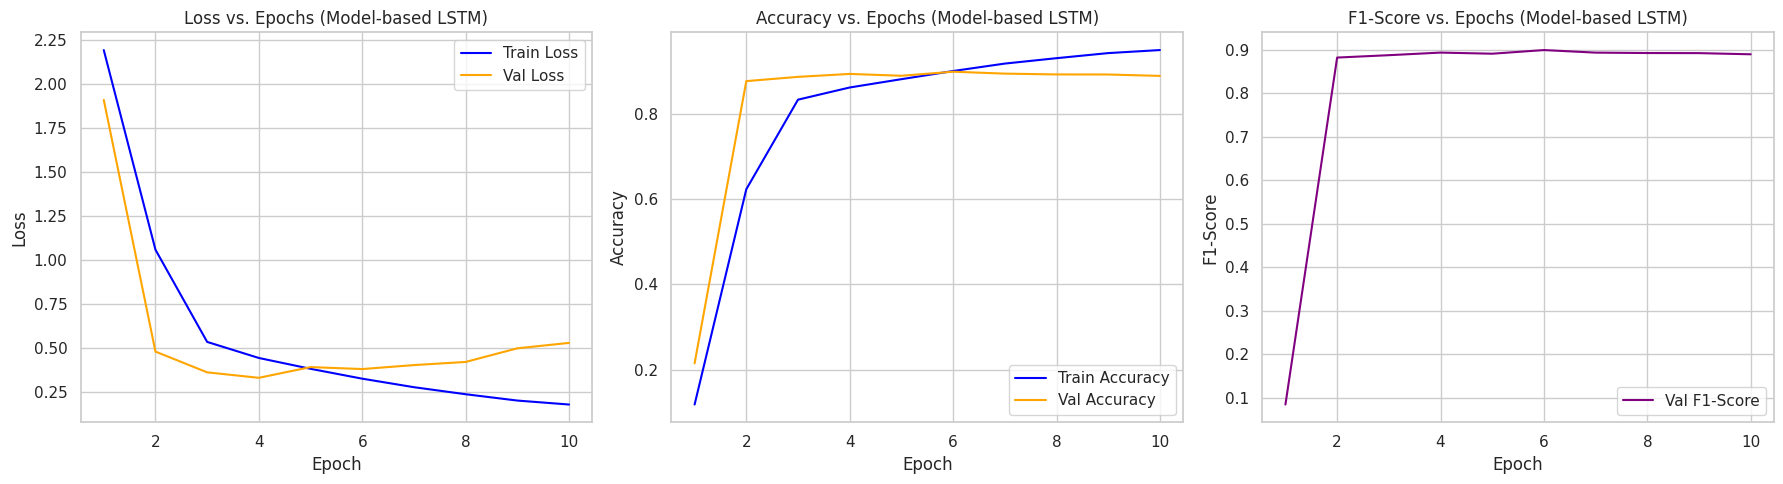

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st plot
sns.lineplot(x=range(1, len(train_losses) + 1), y=train_losses, label='Train Loss', color='blue')
sns.lineplot(x=range(1, len(val_losses) + 1), y=val_losses, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs (Model-based LSTM)')
plt.legend()

plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd plot
sns.lineplot(x=range(1, len(train_accuracies) + 1), y=train_accuracies, label='Train Accuracy', color='blue')
sns.lineplot(x=range(1, len(val_accuracies) + 1), y=val_accuracies, label='Val Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs (Model-based LSTM)')
plt.legend()

plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd plot
sns.lineplot(x=range(1, len(val_f1s) + 1), y=val_f1s, label='Val F1-Score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Epochs (Model-based LSTM)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
hidden_states, labels = get_hidden_states(model, val_loader, device)
tsne = TSNE(n_components=2, perplexity=50, learning_rate=200)
tsne_result = tsne.fit_transform(hidden_states)

plt.figure(figsize=(12, 5))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette="viridis", alpha=0.7)
plt.title("t-SNE Visualization of GRU Hidden States during forward pass")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Class")

plt.tight_layout()
plt.grid(True)
plt.show()

### Optimization phase

The choice of hyperparameters for the different models was based on an analysis of the results obtained from the reports generated by Weights & Biases (WandB). These reports were used to identify the best-performing configurations in terms of accuracy, F1-score and training stability

III.1.1 Optimizer selection

In [ ]:
num_epochs = 10
learning_rate = 1e-3
loss_function = torch.nn.CrossEntropyLoss()

optimizers = {
    'Adam': optim.Adam,
    'RMSprop': optim.RMSprop,
    'AdamW': optim.AdamW,
}

for optimizer_name, optimizer_class in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    model = LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=280, hidden_dim=200, num_layers=1, dropout_prob=0.3).to(device)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project='Binary_Class_Optimizer_Tuning_cnn_lstm_Borderline-SMOTE', name=f"{optimizer_name}_run", config={
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'optimizer': optimizer_name,
        'model': 'CNN_LSTM_Model',
        'embedding_dim': 128,
        'hidden_dim': 167,
        'dropout_prob': 0.5
    })

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    # Progress bar for training
    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"Optimizer: {optimizer_name} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: Adam


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto (wilfried-mvomoeto-university-of-li-ge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


CNN_LSTM_Model(
  (embedding): Embedding(40002, 280)
  (conv1): Conv1d(280, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 200, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=200, out_features=9, bias=True)
)
Total trainable parameters: 11558169


Optimizer: Adam | Epoch 10/10 - Train Loss: 2.1841, Val Loss: 2.2171, Train ACC: 11.48%, Val ACC: 11.45%, Time: 0.49 min: 100%|██████████| 10/10 [05:44<00:00, 34.41s/epoch]


train_acc,▁▂▁▂▃▃▆▄█▆
train_loss,██▇▆▄▃▂▂▁▁
val_acc,▇▇█▇█▁▇▇▅▇
val_f1,▇██▇█▁▇▇▅▇
val_loss,▁▁▂▂▃▅▆▅▆█
train_acc,0.11482
train_loss,2.18405
val_acc,0.11452
val_f1,0.02472
val_loss,2.21706



🔹 Training with optimizer: RMSprop


CNN_LSTM_Model(
  (embedding): Embedding(40002, 280)
  (conv1): Conv1d(280, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 200, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=200, out_features=9, bias=True)
)
Total trainable parameters: 11558169


Optimizer: RMSprop | Epoch 10/10 - Train Loss: 0.2492, Val Loss: 0.4532, Train ACC: 92.70%, Val ACC: 88.88%, Time: 0.46 min: 100%|██████████| 10/10 [04:37<00:00, 27.71s/epoch]


train_acc,▁▁▁▆▇▇████
train_loss,███▃▂▂▁▁▁▁
val_acc,▁▁▃███████
val_f1,▁▁▃███████
val_loss,██▅▁▁▁▁▁▁▁
train_acc,0.92701
train_loss,0.24918
val_acc,0.88875
val_f1,0.89039
val_loss,0.45319



🔹 Training with optimizer: AdamW


CNN_LSTM_Model(
  (embedding): Embedding(40002, 280)
  (conv1): Conv1d(280, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 200, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=200, out_features=9, bias=True)
)
Total trainable parameters: 11558169


Optimizer: AdamW | Epoch 10/10 - Train Loss: 2.1853, Val Loss: 2.2079, Train ACC: 11.30%, Val ACC: 11.61%, Time: 0.50 min: 100%|██████████| 10/10 [05:02<00:00, 30.22s/epoch]


train_acc,▁▄▃▅▃█▇▃█▅
train_loss,█▇▇▆▅▄▃▂▁▁
val_acc,▁▅▇▇▇▇▅█▇▇
val_f1,▁▄▇▇▇▇▄█▇▇
val_loss,▂▁▁▄▃▃▄▅█▆
train_acc,0.113
train_loss,2.18534
val_acc,0.11607
val_f1,0.02646
val_loss,2.20786


---
RMSprop is selected as optimizer.

III.1.2 Learning rate value selection

In [ ]:
learning_rates = [8e-4, 1e-3, 7e-4]

for lr in learning_rates:
    print(f"\n🔹 Training with RMSprop and learning rate: {lr}")

    model = LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=280, hidden_dim=200, num_layers=1, dropout_prob=0.3).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=lr)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',, project='Binary_Class_learning_rate_tuning_cnn_lstm_Borderline-SMOTE', name=f"RMSprop_lr_{lr}", config={
        'learning_rate': lr,
        'num_epochs': num_epochs,
        'optimizer': 'RMSprop',
        'model': 'LSTM_CNN_Model',
        'embedding_dim': 250,
        'hidden_dim': 167,
        'dropout_prob': 0.5
    })

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []
    with tqdm(total=num_epochs, desc=f"LR: {lr}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"LR: {lr} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACSA: {train_acc:.2%}, Val ACSA: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1
            })

    wandb.finish()


🔹 Training with RMSprop and learning rate: 0.0008


LR: 0.0008 | Epoch 10/10 - Train Loss: 2.1851, Val Loss: 2.2137, Train ACSA: 11.78%, Val ACSA: 9.71%, Time: 0.51 min: 100%|██████████| 10/10 [05:24<00:00, 32.44s/epoch]


train_acc,▂▁▁▅▅▆▇▆▅█
train_loss,█▇▆▄▃▂▁▃▁▁
val_acc,▁██▆▆▆▁██▁
val_f1,▂██▆▆▆▂▇█▁
val_loss,▁▁▁▃▄▅▇▆██
train_acc,0.11784
train_loss,2.18508
val_acc,0.0971
val_f1,0.0182
val_loss,2.21372



🔹 Training with RMSprop and learning rate: 0.001


LR: 0.001 | Epoch 10/10 - Train Loss: 0.2496, Val Loss: 0.4440, Train ACSA: 92.82%, Val ACSA: 88.89%, Time: 0.55 min: 100%|██████████| 10/10 [05:10<00:00, 31.10s/epoch]


train_acc,▁▁▃▇▇▇████
train_loss,██▆▃▂▂▁▁▁▁
val_acc,▁▁▆███████
val_f1,▁▁▆███████
val_loss,██▄▁▁▁▁▁▁▁
train_acc,0.92817
train_loss,0.24959
val_acc,0.88893
val_f1,0.88933
val_loss,0.44403



🔹 Training with RMSprop and learning rate: 0.0007


LR: 0.0007 | Epoch 10/10 - Train Loss: 2.1856, Val Loss: 2.2155, Train ACSA: 11.34%, Val ACSA: 11.61%, Time: 0.46 min: 100%|██████████| 10/10 [04:51<00:00, 29.11s/epoch]


train_acc,▁▄▃▃▃▆▅▇█▄
train_loss,█▇▆▅▃▂▂▂▁▂
val_acc,▇▅█▁▁▇▅▇▇▇
val_f1,▇▄█▁▁▇▄▇▇▇
val_loss,▁▁▁▄▅▄▇▇▆█
train_acc,0.1134
train_loss,2.18559
val_acc,0.11607
val_f1,0.02789
val_loss,2.21554


---

III.1.3 Embedding dimension value selection

In [ ]:
embedding_dims = [100, 250, 320]
learning_rate = 1e-3

for embedding_dim in embedding_dims:
    print(f"\n🔹 Training with embedding_dim: {embedding_dim}\n")
    run_name = f"CNN_LSTM_Embedding_{embedding_dim}"
    model = LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=embedding_dim, hidden_dim=200, num_layers=1, dropout_prob=0.3).to(device)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Binary_Class_CNN_LSTM_Embedding_Tuning_Borderline-SMOTE",
        name=run_name,
        config={
            "embedding_dim": embedding_dim,
            "learning_rate": learning_rate,
            "epochs": num_epochs,
            "hidden_dim": 167,
            "dropout": 0.5,
            "optimizer": "AdamW"
        }
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    with tqdm(total=num_epochs, desc=f"Training with Embedding={embedding_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with embedding_dim: 100



Epoch 10/10 - Train Loss: 2.1851, Val Loss: 2.2190, Train Acc: 11.65%, Val Acc: 12.25%, Val F-1: 2.75%,, Time: 0.37 min: 100%|██████████| 10/10 [03:39<00:00, 21.91s/epoch]


train_acc,▃▅▁▅▂▄▇▃██
train_loss,█▇▆▅▄▂▂▁▁▁
val_acc,▇▁█▅▇█▅▇▄█
val_f1,▇▁▇▄▇█▄▇▄▇
val_loss,▁▂▂▃▃▄▆▅█▇
train_acc,0.11648
train_loss,2.1851
val_acc,0.12246
val_f1,0.02753
val_loss,2.21896



🔹 Training with embedding_dim: 250



Epoch 10/10 - Train Loss: 2.1844, Val Loss: 2.2063, Train Acc: 12.19%, Val Acc: 12.94%, Val F-1: 5.06%,, Time: 0.44 min: 100%|██████████| 10/10 [04:24<00:00, 26.47s/epoch]


train_acc,▁▁▂▄▃▅▅▅▃█
train_loss,█▇▇▄▃▂▂▁▁▁
val_acc,▅▇▅▆▁▇▁▅▆█
val_f1,▂▃▃▃▁▃▁▂▃█
val_loss,▂▁▃▃▄▄▆█▇▅
train_acc,0.12188
train_loss,2.18439
val_acc,0.12935
val_f1,0.05064
val_loss,2.20627



🔹 Training with embedding_dim: 320



Epoch 10/10 - Train Loss: 0.1705, Val Loss: 0.5185, Train Acc: 95.38%, Val Acc: 88.91%, Val F-1: 88.95%,, Time: 0.48 min: 100%|██████████| 10/10 [04:48<00:00, 28.84s/epoch]


train_acc,▁▆▇▇▇█████
train_loss,█▄▂▂▂▁▁▁▁▁
val_acc,▁█████████
val_f1,▁█████████
val_loss,█▁▁▁▁▁▁▂▂▂
train_acc,0.95376
train_loss,0.17053
val_acc,0.8891
val_f1,0.88954
val_loss,0.51853


---
Embedding dimension value is set to 280.

III. Depth value selection

In [ ]:
depth_values = [1, 2, 3]
learning_rate = 1e-3

for num_layers in depth_values:
    print(f"\n🔹 Training with GRU Depth (num_layers): {num_layers}\n")

    run_name = f"LSTM_Depth_{num_layers}"
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Binary-Class-CNN-LSTM-Depth-Tuning_Borderline-SMOTE",
        name=run_name,
        config={
            "num_layers": num_layers,
            "learning_rate": learning_rate,
            "hidden_dim":167,
            "dropout":0.5,
            "optimizer": "AdamW"
        }
    )
    model = LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=280, hidden_dim=200, num_layers=num_layers, dropout_prob=0.3).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Training with CNN-LSTM Depth={num_layers}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with GRU Depth (num_layers): 1



Epoch 10/10 - Train Loss: 0.2200, Val Loss: 0.4334, Train Acc: 93.56%, Val Acc: 88.86%, Val F-1: 88.94%,, Time: 0.46 min: 100%|██████████| 10/10 [04:36<00:00, 27.64s/epoch]


train_acc,▁▁▄▇▇▇████
train_loss,██▅▂▂▂▁▁▁▁
val_acc,▁▁████████
val_f1,▁▁████████
val_loss,██▁▁▁▁▁▁▁▁
train_acc,0.93559
train_loss,0.21998
val_acc,0.88858
val_f1,0.8894
val_loss,0.43342



🔹 Training with GRU Depth (num_layers): 2



Epoch 10/10 - Train Loss: 0.2919, Val Loss: 0.4074, Train Acc: 91.69%, Val Acc: 89.34%, Val F-1: 89.41%,, Time: 0.64 min: 100%|██████████| 10/10 [06:21<00:00, 38.15s/epoch]


train_acc,▁▁▅▇▇█████
train_loss,██▅▂▂▂▁▁▁▁
val_acc,▁▂▇███████
val_f1,▁▂▇███████
val_loss,█▇▂▁▁▁▁▁▁▁
train_acc,0.91693
train_loss,0.29186
val_acc,0.89341
val_f1,0.89408
val_loss,0.4074



🔹 Training with GRU Depth (num_layers): 3



Epoch 10/10 - Train Loss: 0.6794, Val Loss: 0.5072, Train Acc: 79.77%, Val Acc: 84.99%, Val F-1: 85.61%,, Time: 0.84 min: 100%|██████████| 10/10 [11:17<00:00, 67.71s/epoch]


train_acc,▁▁▁▁▁▁▁▃▆█
train_loss,███████▆▂▁
val_acc,▁▁▁▁▁▁▁▅██
val_f1,▁▁▁▁▁▁▁▅▇█
val_loss,███████▃▁▁
train_acc,0.79767
train_loss,0.67938
val_acc,0.84995
val_f1,0.85613
val_loss,0.50722


---
Depth value is set to 1.

III.1.4 Batch size value selection

In [ ]:
batch_sizes = [8, 16, 64]

for batch_size in batch_sizes:
    print(f"\n🔹 Training with batch size: {batch_size}")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

    model = LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=280, hidden_dim=200, num_layers=1, dropout_prob=0.3).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Binary-Class-batch_size_comparison_lstm_Borderline-SMOTE",
        name=f"LSTM_Batch_{batch_size}",
        config={
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "num_epochs": num_epochs,
            "optimizer": "Adam",
            "hidden_dim": 167,
            "dropout_prob": 0.5
        }
    )

    print(model)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    with tqdm(total=num_epochs, desc=f"Training with Embedding={embedding_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with batch size: 8


CNN_LSTM_Model(
  (embedding): Embedding(40002, 280)
  (conv1): Conv1d(280, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 200, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=200, out_features=9, bias=True)
)
Total trainable parameters: 11558169


Epoch 10/10 - Train Loss: 0.3854, Val Loss: 0.4037, Train Acc: 89.42%, Val Acc: 88.63%, Val F-1: 88.70%,, Time: 0.80 min: 100%|██████████| 10/10 [09:45<00:00, 58.55s/epoch]


train_acc,▁▁▁▁▄▇████
train_loss,████▅▂▂▁▁▁
val_acc,▁▁▁▃▆█████
val_f1,▁▁▁▃▇█████
val_loss,███▇▃▁▁▁▁▁
train_acc,0.89419
train_loss,0.38536
val_acc,0.88634
val_f1,0.88699
val_loss,0.40372



🔹 Training with batch size: 16


CNN_LSTM_Model(
  (embedding): Embedding(40002, 280)
  (conv1): Conv1d(280, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 200, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=200, out_features=9, bias=True)
)
Total trainable parameters: 11558169


Epoch 10/10 - Train Loss: 0.3270, Val Loss: 0.4548, Train Acc: 90.53%, Val Acc: 88.70%, Val F-1: 88.79%,, Time: 0.47 min: 100%|██████████| 10/10 [04:36<00:00, 27.68s/epoch]


train_acc,▁▁▁▅▇▇████
train_loss,███▄▃▂▂▁▁▁
val_acc,▁▁▃▇██████
val_f1,▁▁▃▇██████
val_loss,██▅▂▂▁▁▁▁▁
train_acc,0.90533
train_loss,0.32703
val_acc,0.88703
val_f1,0.88787
val_loss,0.45483



🔹 Training with batch size: 64


CNN_LSTM_Model(
  (embedding): Embedding(40002, 280)
  (conv1): Conv1d(280, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 200, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=200, out_features=9, bias=True)
)
Total trainable parameters: 11558169


Epoch 10/10 - Train Loss: 0.2976, Val Loss: 0.3878, Train Acc: 90.93%, Val Acc: 89.07%, Val F-1: 89.18%,, Time: 0.24 min: 100%|██████████| 10/10 [02:21<00:00, 14.11s/epoch]


train_acc,▁▁▁▃▆▇████
train_loss,███▅▃▂▂▁▁▁
val_acc,▁▁▂▅██████
val_f1,▁▁▂▅██████
val_loss,███▃▁▁▁▁▁▁
train_acc,0.90931
train_loss,0.29765
val_acc,0.89065
val_f1,0.89182
val_loss,0.38782


---
Batch size value is set to 16.

---
## III.2 **Borderline-SMOTE - GRU - Glove**

## Validation phase

In [ ]:
model = GRU_Model(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=335,
    num_layers=1,
    dropout_prob=0.3,
    embedding_weights=embedding_matrix,
    freeze_embeddings=False
).to(device)

print(model)
num_params = count_parameters(model)
print()
print(f"Total trainable parameters: {num_params}")

GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 335, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=335, out_features=9, bias=True)
)

Total trainable parameters: 12643809


In [ ]:
learning_rate = 1e-3
num_epochs = 10
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1s = []

with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as pbar:
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)

        end_time = time.time()
        epoch_duration = end_time - start_time

        pbar.set_description(
            f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
            f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F1: {val_f1:.2%}, Time: {epoch_duration / 60:.2f} min"
        )
        pbar.update(1)

Epoch 10/10 - Train Loss: 0.0669, Val Loss: 0.4130, Train Acc: 98.01%, Val Acc: 90.03%, Val F1: 90.14%, Time: 0.44 min: 100%|██████████| 10/10 [04:32<00:00, 27.29s/epoch]


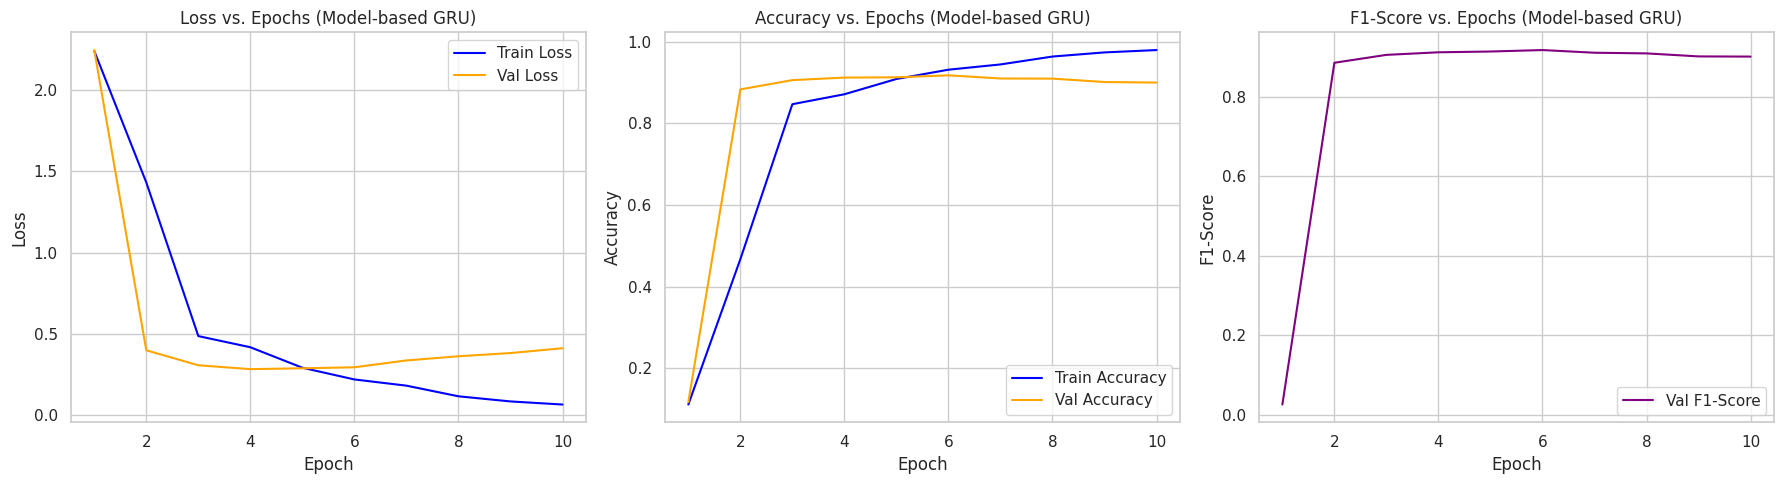

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st plot
sns.lineplot(x=range(1, len(train_losses) + 1), y=train_losses, label='Train Loss', color='blue')
sns.lineplot(x=range(1, len(val_losses) + 1), y=val_losses, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs (Model-based GRU)')
plt.legend()

plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd plot
sns.lineplot(x=range(1, len(train_accuracies) + 1), y=train_accuracies, label='Train Accuracy', color='blue')
sns.lineplot(x=range(1, len(val_accuracies) + 1), y=val_accuracies, label='Val Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs (Model-based GRU)')
plt.legend()

plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd plot
sns.lineplot(x=range(1, len(val_f1s) + 1), y=val_f1s, label='Val F1-Score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Epochs (Model-based GRU)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
hidden_states, labels = get_hidden_states(model, val_loader, device)
tsne = TSNE(n_components=2, perplexity=50, learning_rate=200)
tsne_result = tsne.fit_transform(hidden_states)

plt.figure(figsize=(12, 5))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette="viridis", alpha=0.7)
plt.title("t-SNE Visualization of GRU Hidden States during forward pass")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Class")

plt.tight_layout()
plt.grid(True)
plt.show()

## Optimization phase

The choice of hyperparameters for the different models was based on an analysis of the results obtained from the reports generated by Weights & Biases (WandB). These reports were used to identify the best-performing configurations in terms of accuracy, F1-score and training stability

III.2.1 Optimizer selection

In [ ]:
num_epochs = 10
learning_rate = 1e-3
loss_function = torch.nn.CrossEntropyLoss()

optimizers = {
    'RMSprop': optim.RMSprop,
    'Adam': optim.Adam,
    'AdamW': optim.AdamW,
}

for optimizer_name, optimizer_class in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=335, num_layers=1,dropout_prob=0.3, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project='Binary_Class_Optimizer_Comparison_gru_glove300d_Borderline-SMOTE', name=f"{optimizer_name}_run", config={
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'optimizer': optimizer_name,
        'model': 'GRU_Model',
        'embedding_dim': 300,
        'hidden_dim': 350,
        'dropout_prob': 0.5
    })

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    # Progress bar for training
    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"Optimizer: {optimizer_name} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: RMSprop


train_acc,▁▂▃▅▆▂█
train_loss,▆▄▃▁▁█▃
val_acc,█▇▁█▁█▇
val_f1,█▇▁█▁██
val_loss,▁▂▃▅█▄▃
train_acc,0.11933
train_loss,2.19179
val_acc,0.1159
val_f1,0.02979
val_loss,2.19932


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 335, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=335, out_features=9, bias=True)
)
Total trainable parameters: 12643809


Optimizer: RMSprop | Epoch 10/10 - Train Loss: 0.2813, Val Loss: 0.2708, Train ACC: 91.09%, Val ACC: 92.03%, Time: 0.44 min: 100%|██████████| 10/10 [04:24<00:00, 26.49s/epoch]


train_acc,▁▁▁▁▁▁▁▇██
train_loss,███████▂▁▁
val_acc,▁▁▁▁▁▁▂███
val_f1,▁▁▁▁▁▁▂███
val_loss,███████▁▁▁
train_acc,0.91087
train_loss,0.28129
val_acc,0.92032
val_f1,0.9198
val_loss,0.27084



🔹 Training with optimizer: Adam


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 335, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=335, out_features=9, bias=True)
)
Total trainable parameters: 12643809


Optimizer: Adam | Epoch 10/10 - Train Loss: nan, Val Loss: nan, Train ACC: 11.11%, Val ACC: 12.21%, Time: 0.39 min: 100%|██████████| 10/10 [04:01<00:00, 24.12s/epoch]


train_acc,▁▄█▃▃▃▃▃▃▃
train_loss,█▁
val_acc,█▁████████
val_f1,█▁▆▆▆▆▆▆▆▆
val_loss,█▁
train_acc,0.11111
train_loss,nan
val_acc,0.12211
val_f1,0.02658
val_loss,nan



🔹 Training with optimizer: AdamW


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 335, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=335, out_features=9, bias=True)
)
Total trainable parameters: 12643809


Optimizer: AdamW | Epoch 10/10 - Train Loss: 2.1856, Val Loss: 2.2050, Train ACC: 11.81%, Val ACC: 11.64%, Time: 0.45 min: 100%|██████████| 10/10 [04:29<00:00, 26.93s/epoch]


train_acc,▁▂▇▄▅▃▆▇▇█
train_loss,█▆▄█▅▂▁▁▁▁
val_acc,▁▇▇█▇██▁▇▇
val_f1,▁▇▇█▆██▂▇▇
val_loss,▂▂▃▄▁▄▄▇█▆
train_acc,0.11814
train_loss,2.18558
val_acc,0.11642
val_f1,0.0268
val_loss,2.205


---

III.2.2 Learning rate value selection

In [ ]:
learning_rates = [1e-3, 2e-3, 5e-3]

for lr in learning_rates:
    print(f"\n🔹 Training with RMSprop and learning rate: {lr}")

    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=335, num_layers=1,dropout_prob=0.3, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=lr)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project='Binary_Class_learning_rate_tuning_gru_glove300d_Borderline-SMOTE', name=f"RMSprop_lr_{lr}", config={
        'learning_rate': lr,
        'num_epochs': num_epochs,
        'optimizer': 'RMPprop',
        'model': 'GRU_Model',
        'embedding_dim': 300,
        'hidden_dim': 350,
        'dropout_prob': 0.5
    })

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []
    with tqdm(total=num_epochs, desc=f"LR: {lr}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"LR: {lr} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACSA: {train_acc:.2%}, Val ACSA: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1
            })

    wandb.finish()


🔹 Training with RMSprop and learning rate: 0.001


LR: 0.001 | Epoch 10/10 - Train Loss: 2.1856, Val Loss: 2.2084, Train ACSA: 11.60%, Val ACSA: 7.19%, Time: 0.44 min: 100%|██████████| 10/10 [04:24<00:00, 26.46s/epoch]


train_acc,▂▁█▇▇▃▄▆▆▆
train_loss,▇▅▇▃▁▁▁█▁▁
val_acc,██▇▁█▇▇█▇▁
val_f1,▃▃▃▁▃█▃▃▃▁
val_loss,▂▁█▄▃▅▅▄▄▅
train_acc,0.11602
train_loss,2.18562
val_acc,0.07192
val_f1,0.01184
val_loss,2.20845



🔹 Training with RMSprop and learning rate: 0.002


LR: 0.002 | Epoch 10/10 - Train Loss: 0.0421, Val Loss: 0.4527, Train ACSA: 98.59%, Val ACSA: 90.72%, Time: 0.44 min: 100%|██████████| 10/10 [04:25<00:00, 26.56s/epoch]


train_acc,▁▅▆▇██████
train_loss,█▄▃▂▂▁▁▁▁▁
val_acc,▁█▇▅▄▂▃▄▃▃
val_f1,▁█▇▅▄▂▃▄▃▃
val_loss,▃▁▂▄▅▆▆▇██
train_acc,0.98588
train_loss,0.04206
val_acc,0.90721
val_f1,0.90776
val_loss,0.45274



🔹 Training with RMSprop and learning rate: 0.005


LR: 0.005 | Epoch 10/10 - Train Loss: nan, Val Loss: nan, Train ACSA: 11.11%, Val ACSA: 12.21%, Time: 0.38 min: 100%|██████████| 10/10 [03:48<00:00, 22.88s/epoch]


train_acc,█▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_f1,▁▁▁▁▁▁▁▁▁▁
train_acc,0.11111
train_loss,nan
val_acc,0.12211
val_f1,0.02658
val_loss,nan


---

III.1.3 Hidden dimension value selection

In [ ]:
hidden_dims = [100, 250, 400]
learning_rate = 1e-3

for hidden_dim in hidden_dims:
    print(f"\n🔹 Training with hidden_dim: {hidden_dim}\n")
    run_name = f"GRU_Hidden_{hidden_dim}"

    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=335, num_layers=1,dropout_prob=0.3, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Binary_Class_GRU-Hidden-Tuning-glove300d_Attention_Borderline-SMOTE",
        name=run_name,
        config={
            "embedding_dim": EMBEDDING_DIM,
            "learning_rate": learning_rate,
            "epochs": num_epochs,
            "hidden_dim": 200,
            "dropout": 0.4,
            "optimizer": "RMSprop"
        }
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    with tqdm(total=num_epochs, desc=f"Training with Hidden={hidden_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with hidden_dim: 100



Epoch 10/10 - Train Loss: 2.1961, Val Loss: 2.2033, Train Acc: 11.21%, Val Acc: 11.56%, Val F-1: 2.47%,, Time: 0.44 min: 100%|██████████| 10/10 [04:24<00:00, 26.49s/epoch]


train_acc,▁█▃▇▄▄▆█▃▄
train_loss,▃▂▃▂▂▅▁█▂▂
val_acc,█▁█▆▆▁▆▆▆▆
val_f1,█▂█▆▅▁▅▆▆▅
val_loss,▁▂▂▂▅▃█▂▅▄
train_acc,0.11207
train_loss,2.19613
val_acc,0.11556
val_f1,0.02472
val_loss,2.20333



🔹 Training with hidden_dim: 250



Epoch 10/10 - Train Loss: 0.2598, Val Loss: 0.3634, Train Acc: 92.15%, Val Acc: 90.08%, Val F-1: 90.12%,, Time: 0.45 min: 100%|██████████| 10/10 [04:27<00:00, 26.78s/epoch]


train_acc,▁▁▁▁▁▃▇███
train_loss,█████▆▃▂▁▁
val_acc,▁▁▁▁▁▆████
val_f1,▁▁▁▁▁▅████
val_loss,█████▃▁▁▁▁
train_acc,0.92151
train_loss,0.25976
val_acc,0.90083
val_f1,0.90118
val_loss,0.36339



🔹 Training with hidden_dim: 400



Epoch 10/10 - Train Loss: 2.1920, Val Loss: 2.2059, Train Acc: 11.38%, Val Acc: 11.57%, Val F-1: 2.48%,, Time: 0.45 min: 100%|██████████| 10/10 [04:27<00:00, 26.75s/epoch]


train_acc,▁▂▁▄██▃▅▄▄
train_loss,▃▃▂▆█▁▂▆▂▂
val_acc,▄▄▃▃█▁▄▁▄▄
val_f1,▃▃▂▂█▁▃▁▂▃
val_loss,▇▆▇▇▁▇▇█▇▇
train_acc,0.1138
train_loss,2.19197
val_acc,0.11573
val_f1,0.02476
val_loss,2.20591


---

III.2.4 Depth value selection

In [ ]:
depth_values = [1, 2, 3]

for num_layers in depth_values:
    print(f"\n🔹 Training with GRU Depth (num_layers): {num_layers}\n")
    run_name = f"GRU_Depth_{num_layers}"
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Binary-Class-GRU-Depth-Tuning-glove300d_Borderline-SMOTE",
        name=run_name,
        config={
            "num_layers": num_layers,
            "learning_rate": learning_rate,
            "hidden_dim":350,
            "dropout":0.4,
            "optimizer": "RMSprop"
        }
    )
    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=335, num_layers=1,dropout_prob=0.3, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Training with GRU Depth={num_layers}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with GRU Depth (num_layers): 1



Epoch 10/10 - Train Loss: 0.2683, Val Loss: 0.2798, Train Acc: 91.54%, Val Acc: 91.53%, Val F-1: 91.49%,, Time: 0.44 min: 100%|██████████| 10/10 [04:24<00:00, 26.50s/epoch]


train_acc,▁▁▁▁▁▁▂▇██
train_loss,██████▇▂▁▁
val_acc,▁▁▁▁▁▁▇███
val_f1,▁▁▁▁▁▂▇███
val_loss,██████▃▁▁▁
train_acc,0.91541
train_loss,0.26826
val_acc,0.91532
val_f1,0.91486
val_loss,0.27981



🔹 Training with GRU Depth (num_layers): 2



Epoch 10/10 - Train Loss: 2.2020, Val Loss: 2.2124, Train Acc: 11.36%, Val Acc: 9.87%, Val F-1: 2.09%,, Time: 0.44 min: 100%|██████████| 10/10 [04:24<00:00, 26.45s/epoch]


train_acc,▂▃▁▂▅▄▅█▆▃
train_loss,▆▄█▇▃▂▂▁▆▇
val_acc,▁▇▇▇▇█▅█▇▅
val_f1,▁▃▃▃▄▄▂▄█▂
val_loss,▄▁▂▃▃▂▅▅▃█
train_acc,0.11363
train_loss,2.20203
val_acc,0.09865
val_f1,0.02093
val_loss,2.21239



🔹 Training with GRU Depth (num_layers): 3



Epoch 10/10 - Train Loss: 0.0524, Val Loss: 0.4440, Train Acc: 98.37%, Val Acc: 90.84%, Val F-1: 90.87%,, Time: 0.44 min: 100%|██████████| 10/10 [04:25<00:00, 26.58s/epoch]


train_acc,▁▄▇▇▇█████
train_loss,█▆▂▂▂▁▁▁▁▁
val_acc,▁█████████
val_f1,▁█████████
val_loss,█▁▁▁▁▁▁▂▁▂
train_acc,0.98366
train_loss,0.05244
val_acc,0.90842
val_f1,0.90867
val_loss,0.44403


---

III.2.5 Batch value selection

In [ ]:
batch_sizes = [8, 16, 64]

for batch_size in batch_sizes:
    print(f"\n🔹 Training with batch size: {batch_size}")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=335, num_layers=1,dropout_prob=0.3, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Binary-Class-batch_size_comparison_gru_glove300d_Borderline-SMOTE",
        name=f"GRU_Batch_{batch_size}",
        config={
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "num_epochs": num_epochs,
            "optimizer": "RMSprop",
            "hidden_dim": 250,
            "dropout_prob": 0.4
        }
    )

    print(model)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    with tqdm(total=num_epochs, desc=f"Training with Embedding={hidden_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with batch size: 8


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 335, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=335, out_features=9, bias=True)
)
Total trainable parameters: 12643809


Epoch 10/10 - Train Loss: 0.0728, Val Loss: 0.4546, Train Acc: 98.18%, Val Acc: 90.96%, Val F-1: 90.94%,, Time: 1.44 min: 100%|██████████| 10/10 [14:26<00:00, 86.61s/epoch]


train_acc,▁▇▇███████
train_loss,█▃▂▂▁▁▁▁▁▁
val_acc,▁█████████
val_f1,▁█████████
val_loss,█▁▁▁▁▂▂▂▂▂
train_acc,0.98184
train_loss,0.0728
val_acc,0.90962
val_f1,0.90938
val_loss,0.45464



🔹 Training with batch size: 16


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 335, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=335, out_features=9, bias=True)
)
Total trainable parameters: 12643809


Epoch 10/10 - Train Loss: 0.0588, Val Loss: 0.4255, Train Acc: 98.37%, Val Acc: 90.76%, Val F-1: 90.70%,, Time: 0.88 min: 100%|██████████| 10/10 [08:47<00:00, 52.75s/epoch]


train_acc,▁▁▅▇██████
train_loss,██▅▂▂▁▁▁▁▁
val_acc,▁▁████████
val_f1,▁▁████████
val_loss,██▁▁▁▁▁▂▂▂
train_acc,0.98366
train_loss,0.05876
val_acc,0.90755
val_f1,0.907
val_loss,0.42549



🔹 Training with batch size: 64


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 335, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=335, out_features=9, bias=True)
)
Total trainable parameters: 12643809


Epoch 10/10 - Train Loss: 0.0759, Val Loss: 0.4124, Train Acc: 97.82%, Val Acc: 90.63%, Val F-1: 90.62%,, Time: 0.45 min: 100%|██████████| 10/10 [04:30<00:00, 27.04s/epoch]


train_acc,▁▁▁▁▆▇▇███
train_loss,████▃▂▂▁▁▁
val_acc,▁▁▁▅██████
val_f1,▁▁▁▅██████
val_loss,███▅▁▁▁▁▁▂
train_acc,0.97822
train_loss,0.0759
val_acc,0.90635
val_f1,0.90617
val_loss,0.41241


---
# IV. **Test phase - Resampling Technique Comparison**
---

In [ ]:
# Function to get the correct metrics for early stopping
def get_last_saved_metrics(metrics, saved_once):
    if saved_once:
        # Return the last saved epoch's metrics
        return {
            "f1": metrics["test_f1s"][-1],
            "balanced_acc": metrics["test_balanced_accs"][-1],
            "recall": metrics["test_recalls"][-1],
            "precision": metrics["test_precisions"][-1]
        }
    else:
        # If no early stopping, we just take the last epoch's metrics
        return {
            "f1": metrics["test_f1s"][-1],
            "balanced_acc": metrics["test_balanced_accs"][-1],
            "recall": metrics["test_recalls"][-1],
            "precision": metrics["test_precisions"][-1]
        }

In [ ]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device).float().unsqueeze(1)  # Shape: (batch, 1) for BCE

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        preds = torch.sigmoid(outputs) >= 0.5
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc

def test_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).float()

            all_probs.append(probs.cpu())
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_probs = torch.cat(all_probs).numpy()
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, pos_label=1, zero_division=0)
    epoch_recall = recall_score(all_labels, all_preds, pos_label=1, zero_division=0)
    epoch_precision = precision_score(all_labels, all_preds, pos_label=1, zero_division=0)
    epoch_balanced_acc = balanced_accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc, epoch_f1 * 100, epoch_balanced_acc, epoch_recall * 100, epoch_precision * 100


def train_model_with_class_weights(model, train_loader, test_loader, optimizer, class_weights, num_epochs, model_name, technique_name, loss_gap_ratio=1.25, ax_accuracy_gap=5, device="cpu"):
    # Pour binaire, pos_weight est un seul scalaire (le poids de la classe 1)
    pos_weight = torch.tensor(class_weights[1], dtype=torch.float).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    return train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs, model_name, technique_name, loss_gap_ratio, ax_accuracy_gap, device)

In [ ]:
X_combined = torch.cat((X_train_tensor, X_val_tensor), dim=0)
y_combined = torch.cat((y_train_tensor, y_val_tensor), dim=0)
raw_text_combined = np.concatenate((X_train, X_val))

X_combined_np = X_combined.cpu().numpy()
y_combined_np = y_combined.cpu().numpy()

train_dataset_no_oversampling = TextDataset(X_combined, y_combined, raw_text_data=raw_text_combined)
train_loader_no_oversampling = DataLoader(train_dataset_no_oversampling, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled_np, y_resampled_np = smote.fit_resample(X_combined_np, y_combined_np)
X_resampled_tensor = torch.tensor(X_resampled_np, dtype=torch.float).to(device)
y_resampled_tensor = torch.tensor(y_resampled_np, dtype=torch.long).to(device)

train_dataset_smote = TextDataset(X_resampled_tensor, y_resampled_tensor, raw_text_data=raw_text_combined)
train_loader_smote = DataLoader(train_dataset_smote, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

borderline_smote = BorderlineSMOTE(sampling_strategy='auto', random_state=42)
X_resampled_borderline_np, y_resampled_borderline_np = borderline_smote.fit_resample(X_combined_np, y_combined_np)
X_resampled_borderline_tensor = torch.tensor(X_resampled_borderline_np, dtype=torch.float).to(device)
y_resampled_borderline_tensor = torch.tensor(y_resampled_borderline_np, dtype=torch.long).to(device)

train_dataset_borderline_smote = TextDataset(X_resampled_borderline_tensor, y_resampled_borderline_tensor, raw_text_data=raw_text_combined)
train_loader_borderline_smote = DataLoader(train_dataset_borderline_smote, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

<ipython-input-9-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-9-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)
<ipython-input-9-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-9-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

### IV.1. **LSTM**

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_tensor.cpu().numpy()), y=y_train_tensor.cpu().numpy())

embedding_dim_no_oversampling = 250
hidden_dim_no_oversampling = 167
dropout_prob_no_oversampling = 0.3
model_name_no_oversampling = "LSTM_No_Oversampling"
model_no_oversampling = CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=embedding_dim_no_oversampling, hidden_dim=hidden_dim_no_oversampling, num_layers=1, dropout_prob=dropout_prob_no_oversampling).to(device)
optimizer_no_oversampling = optim.AdamW(model_no_oversampling.parameters(), lr=7e-4)

embedding_dim_smote = 250
hidden_dim_smote = 200
dropout_prob_smote = 0.3
model_name_smote = "LSTM_SMOTE"
model_smote = CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=embedding_dim_smote, hidden_dim=hidden_dim_smote, num_layers=1, dropout_prob=dropout_prob_smote).to(device)
optimizer_smote = optim.AdamW(model_smote.parameters(), lr=7e-4)

embedding_dim_borderline_smote = 280
hidden_dim_borderline_smote = 200
dropout_prob_borderline_smote = 0.3
model_name_borderline_smote = "LSTM_Borderline_SMOTE"
model_borderline_smote = CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=embedding_dim_borderline_smote, hidden_dim=hidden_dim_borderline_smote, num_layers=1, dropout_prob=dropout_prob_borderline_smote).to(device)
optimizer_borderline_smote = optim.AdamW(model_borderline_smote.parameters(), lr=7e-4)

embedding_dim_class_weights = 250
hidden_dim_class_weights = 200
dropout_prob_class_weights = 0.3
model_name_class_weights = "LSTM_class_weights"
model_class_weights = CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=embedding_dim_class_weights, hidden_dim=hidden_dim_class_weights, num_layers=1, dropout_prob=dropout_prob_class_weights).to(device)
optimizer_class_weights = optim.Adam(model_class_weights.parameters(), lr=9e-4)

criterion = nn.BCEWithLogitsLoss()

wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project="Binary-Class-Resampling Technique Comparison - CNN-LSTM", name="Borderline-SMOTE")

# Borderline-SMOTE
metrics_borderline_smote = train_model(
    model_borderline_smote,
    train_loader_borderline_smote,
    test_loader,
    optimizer_borderline_smote,
    criterion,
    num_epochs=40,
    model_name=model_name_borderline_smote,
    technique_name="Borderline-SMOTE",
    device=device
)

wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project="Binary-Class-Resampling Technique Comparison - CNN-LSTM", name="Class Weights")

# Class Weights
metrics_class_weights = train_model_with_class_weights(
    model_class_weights,
    train_loader_no_oversampling,
    test_loader,
    optimizer_class_weights,
    class_weights_tensor,
    num_epochs=40,
    model_name=model_name_class_weights,
    technique_name="Class Weights",
    device=device
)

wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project="Binary-Class-Resampling Technique Comparison - CNN-LSTM", name="No Oversampling")

# No Oversampling
metrics_no_oversampling = train_model(
    model_no_oversampling,
    train_loader_no_oversampling,
    test_loader,
    optimizer_no_oversampling,
    criterion,
    num_epochs=40,
    model_name=model_name_no_oversampling,
    technique_name="No Oversampling",
    device=device
)

wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project="Binary-Class-Resampling Technique Comparison - CNN-LSTM", name="SMOTE")

# SMOTE
metrics_smote = train_model(
    model_smote,
    train_loader_smote,
    test_loader,
    optimizer_smote,
    criterion,
    num_epochs=40,
    model_name=model_name_smote,
    technique_name="SMOTE",
    device=device
)

# Dictionary of metrics for all techniques
metrics_dict = {
    "No Oversampling": metrics_no_oversampling[model_name_no_oversampling],
    "SMOTE": metrics_smote[model_name_smote],
    "Borderline-SMOTE": metrics_borderline_smote[model_name_borderline_smote],
    "Class Weights": metrics_class_weights[model_name_class_weights]
}

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


CNN_LSTM_Borderline_SMOTE Epoch 15/40 - Train Loss: 0.3689, Test Loss: 0.4128, Train Acc: 88.79%, Test Acc: 87.79%, Test F1: 87.87%, Test Balanced Acc: 88.28%, Test Recall: 87.79%, Time: 0.61 min:  38%|███▊      | 15/40 [09:43<16:11, 38.87s/epoch]


test_acc,▁▁▁▁▁▁▁▁▁▄▅▇████
test_balanced_acc,▁▁▁▁▁▁▁▁▁▃▄▇████
test_f1,▁▁▁▁▁▁▁▁▁▄▄▇████
test_loss,█████████▅▄▂▁▁▁▁
test_precision,▁▂▁▁▁▁▁▁▂▄▅▇████
test_recall,▁▁▁▁▁▁▁▁▁▄▅▇████
train_acc,▁▁▁▁▁▁▁▁▁▂▄▆▇███
train_loss,█████████▇▅▃▂▁▁▁
test_acc,0.89151
test_balanced_acc,0.89526
test_f1,0.89248


CNN_LSTM_class_weights Epoch 24/40 - Train Loss: 0.2993, Test Loss: 0.3735, Train Acc: 90.52%, Test Acc: 88.46%, Test F1: 88.57%, Test Balanced Acc: 88.77%, Test Recall: 88.46%, Time: 0.52 min:  60%|██████    | 24/40 [12:57<08:38, 32.38s/epoch]


test_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▄▅█████
test_balanced_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▄▅█████
test_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▄▅█████
test_loss,████████████████▇▅▅▃▁▁▁▁▁
test_precision,▁▁▂▂▂▁▁▂▂▂▂▂▂▁▂▂▂▄▄▅█████
test_recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▄▅█████
train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▅▆████
train_loss,█████████████████▆▅▄▃▁▁▁▁
test_acc,0.88099
test_balanced_acc,0.88367
test_f1,0.88094


CNN_LSTM_No_Oversampling Epoch 30/40 - Train Loss: 0.3147, Test Loss: 0.3768, Train Acc: 91.09%, Test Acc: 89.13%, Test F1: 89.17%, Test Balanced Acc: 89.40%, Test Recall: 89.13%, Time: 0.64 min:  75%|███████▌  | 30/40 [19:51<06:37, 39.72s/epoch]


test_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▄▇████
test_balanced_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▇████
test_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▇████
test_loss,███████████████████████▇▇▅▂▁▁▁▁
test_precision,▁▁▂▁▁▂▁▂▂▁▁▁▂▂▁▂▁▁▁▁▁▁▂▂▂▄▇████
test_recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▄▇████
train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▅▇███
train_loss,███████████████████████▇▇▇▄▂▁▁▁
test_acc,0.89031
test_balanced_acc,0.8932
test_f1,0.89126


CNN_LSTM_SMOTE Epoch 22/40 - Train Loss: 0.4141, Test Loss: 0.5003, Train Acc: 86.98%, Test Acc: 87.05%, Test F1: 87.04%, Test Balanced Acc: 87.39%, Test Recall: 87.05%, Time: 0.58 min:  55%|█████▌    | 22/40 [13:19<10:54, 36.35s/epoch]


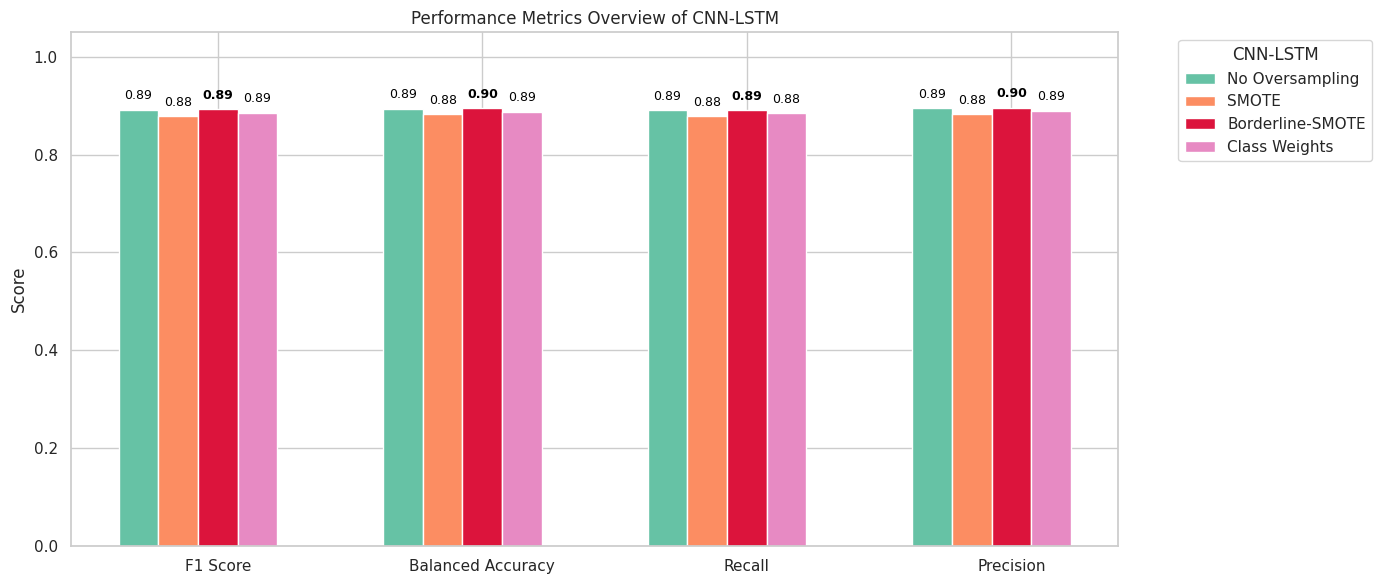

In [ ]:
plot_comparison_histograms(metrics_dict, technique_names=["No Oversampling", "SMOTE", "Borderline-SMOTE", "Class Weights"],model_family_name="CNN-LSTM", title=None)

---

### IV.2. **GRU**

In [ ]:
embedding_dim_gru_glove_no_oversampling = 300
hidden_dim_gru_glove_no_oversampling = 250
dropout_prob_gru_glove_no_oversampling = 0.3
model_name_gru_glove_no_oversampling = "GRU_No_Oversampling"
model_gru_glove_no_oversampling = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=embedding_dim_gru_glove_no_oversampling,
                                            hidden_dim=hidden_dim_gru_glove_no_oversampling, num_layers=1,
                                            dropout_prob=dropout_prob_gru_glove_no_oversampling, embedding_weights=embedding_matrix,
                                            freeze_embeddings=False).to(device)
optimizer_gru_glove_no_oversampling = optim.AdamW(model_gru_glove_no_oversampling.parameters(), lr=7e-4)

embedding_dim_gru_glove_smote = 300
hidden_dim_gru_glove_smote = 250
dropout_prob_gru_glove_smote = 0.3
model_name_gru_glove_smote = "GRU_SMOTE"
model_gru_glove_smote = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=embedding_dim_gru_glove_smote,
                                  hidden_dim=hidden_dim_gru_glove_smote, num_layers=1,
                                  dropout_prob=dropout_prob_gru_glove_smote, embedding_weights=embedding_matrix,
                                  freeze_embeddings=False).to(device)
optimizer_gru_glove_smote = optim.AdamW(model_gru_glove_smote.parameters(), lr=7e-4)

embedding_dim_gru_glove_borderline_smote = 300
hidden_dim_gru_glove_borderline_smote = 250
dropout_prob_gru_glove_borderline_smote = 0.3
model_name_gru_glove_borderline_smote = "GRU_Borderline_SMOTE"
model_gru_glove_borderline_smote = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=embedding_dim_gru_glove_borderline_smote,
                                             hidden_dim=hidden_dim_gru_glove_borderline_smote, num_layers=1,
                                             dropout_prob=dropout_prob_gru_glove_borderline_smote, embedding_weights=embedding_matrix,
                                             freeze_embeddings=False).to(device)
optimizer_gru_glove_borderline_smote = optim.AdamW(model_gru_glove_borderline_smote.parameters(), lr=7e-4)

embedding_dim_gru_glove_class_weights = 300
hidden_dim_gru_glove_class_weights = 250
dropout_prob_gru_glove_class_weights = 0.3
model_name_gru_glove_class_weights = "GRU_class_weights"
model_gru_glove_class_weights = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=embedding_dim_gru_glove_class_weights,
                                          hidden_dim=hidden_dim_gru_glove_class_weights, num_layers=1,
                                          dropout_prob=dropout_prob_gru_glove_class_weights, embedding_weights=embedding_matrix,
                                          freeze_embeddings=False).to(device)
optimizer_gru_glove_class_weights = optim.Adam(model_gru_glove_class_weights.parameters(), lr=9e-4)

criterion = nn.CrossEntropyLoss()

wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project="Binary-Class-Resampling Technique Comparison - Glove-GRU", name="No Oversampling")

# No Oversampling
metrics_gru_glove_no_oversampling = train_model(
    model_gru_glove_no_oversampling,
    train_loader_no_oversampling,
    test_loader,
    optimizer_gru_glove_no_oversampling,
    criterion,
    num_epochs=40,
    model_name=model_name_gru_glove_no_oversampling,
    technique_name="No Oversampling",
    device=device
)

wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project="Binary-Class-Resampling Technique Comparison - Glove-GRU", name="SMOTE")

# SMOTE
metrics_gru_glove_smote = train_model(
    model_gru_glove_smote,
    train_loader_smote,
    test_loader,
    optimizer_gru_glove_smote,
    criterion,
    num_epochs=40,
    model_name=model_name_gru_glove_smote,
    technique_name="SMOTE",
    device=device
)

wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project="Binary-Class-Resampling Technique Comparison - Glove-GRU", name="Borderline-SMOTE")

# Borderline-SMOTE
metrics_gru_glove_borderline_smote = train_model(
    model_gru_glove_borderline_smote,
    train_loader_borderline_smote,
    test_loader,
    optimizer_gru_glove_borderline_smote,
    criterion,
    num_epochs=40,
    model_name=model_name_gru_glove_borderline_smote,
    technique_name="Borderline-SMOTE",
    device=device
)

wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project="Binary-Class-Resampling Technique Comparison - Glove-GRU", name="Class Weights")

# Class Weights
metrics_gru_glove_class_weights = train_model_with_class_weights(
    model_gru_glove_class_weights,
    train_loader_no_oversampling,
    test_loader,
    optimizer_gru_glove_class_weights,
    class_weights_tensor,
    num_epochs=40,
    model_name=model_name_gru_glove_class_weights,
    technique_name="Class Weights",
    device=device
)

# Dictionary of metrics for all techniques
metrics_dict = {
    "No Oversampling (GRU-Glove)": metrics_gru_glove_no_oversampling[model_name_gru_glove_no_oversampling],
    "SMOTE (GRU-Glove)": metrics_gru_glove_smote[model_name_gru_glove_smote],
    "Borderline-SMOTE (GRU-Glove)": metrics_gru_glove_borderline_smote[model_name_gru_glove_borderline_smote],
    "Class Weights (GRU-Glove)": metrics_gru_glove_class_weights[model_name_gru_glove_class_weights],
}

test_acc,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▄▅▆▇▇▇██
test_balanced_acc,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▄▄▆▇▇▇██
test_f1,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▄▄▆▇▇▇██
test_loss,████████████▇▇▇▅▄▂▂▁▁▁▁
test_precision,▁▁▂▁▂▂▂▂▂▂▂▂▃▂▃▄▄▆▇▇▇██
test_recall,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▄▅▆▇▇▇██
train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▄▅▆▇▇██
train_loss,█████████████▇▇▆▅▄▃▂▂▁▁
test_acc,0.87858
test_balanced_acc,0.88273
test_f1,0.8792


GRU_Glove_No_Oversampling Epoch 18/40 - Train Loss: 0.3144, Test Loss: 0.2576, Train Acc: 90.37%, Test Acc: 91.91%, Test F1: 91.91%, Test Balanced Acc: 92.17%, Test Recall: 91.91%, Time: 0.83 min:  45%|████▌     | 18/40 [15:36<19:04, 52.04s/epoch]


test_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆██
test_balanced_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆██
test_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆██
test_loss,████████████████▄▁▁
test_precision,▁▁▁▁▂▂▁▁▁▁▂▂▁▂▁▂▆██
test_recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆██
train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██
train_loss,█████████████████▁▁
test_acc,0.92359
test_balanced_acc,0.9252
test_f1,0.92368


GRU_Glove_SMOTE Epoch 15/40 - Train Loss: 0.2643, Test Loss: 0.2855, Train Acc: 92.03%, Test Acc: 91.48%, Test F1: 91.46%, Test Balanced Acc: 91.75%, Test Recall: 91.48%, Time: 0.90 min:  38%|███▊      | 15/40 [14:23<23:59, 57.58s/epoch]


test_acc,▁▁▁▁▁▁▁▁▁▁▁▁████
test_balanced_acc,▁▁▁▁▁▁▁▁▁▁▁▁████
test_f1,▁▁▁▁▁▁▁▁▁▁▁▁████
test_loss,████████████▁▁▁▁
test_precision,▁▁▂▁▂▂▂▃▂▂▁▂████
test_recall,▁▁▁▁▁▁▁▁▁▁▁▁████
train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▅▇██
train_loss,████████████▅▂▁▁
test_acc,0.90859
test_balanced_acc,0.91121
test_f1,0.90899


GRU_Glove_Borderline_SMOTE Epoch 13/40 - Train Loss: 0.3524, Test Loss: 0.2740, Train Acc: 89.12%, Test Acc: 91.77%, Test F1: 91.77%, Test Balanced Acc: 92.04%, Test Recall: 91.77%, Time: 0.90 min:  32%|███▎      | 13/40 [12:35<26:09, 58.14s/epoch]


test_acc,▁▁▁▁▁▁▁▁▁▁▃███
test_balanced_acc,▁▁▁▁▁▁▁▁▁▁▃███
test_f1,▁▁▁▁▁▁▁▁▁▁▃███
test_loss,██████████▆▁▁▁
test_precision,▁▂▂▁▁▂▁▁▁▁▄███
test_recall,▁▁▁▁▁▁▁▁▁▁▃███
train_acc,▁▁▁▁▁▁▁▁▁▁▁▆██
train_loss,███████████▃▁▁
test_acc,0.91342
test_balanced_acc,0.91653
test_f1,0.91322


GRU_Glove_class_weights Epoch 6/40 - Train Loss: 0.2118, Test Loss: 0.2407, Train Acc: 93.69%, Test Acc: 92.17%, Test F1: 92.22%, Test Balanced Acc: 92.42%, Test Recall: 92.17%, Time: 0.81 min:  15%|█▌        | 6/40 [05:38<31:55, 56.34s/epoch]


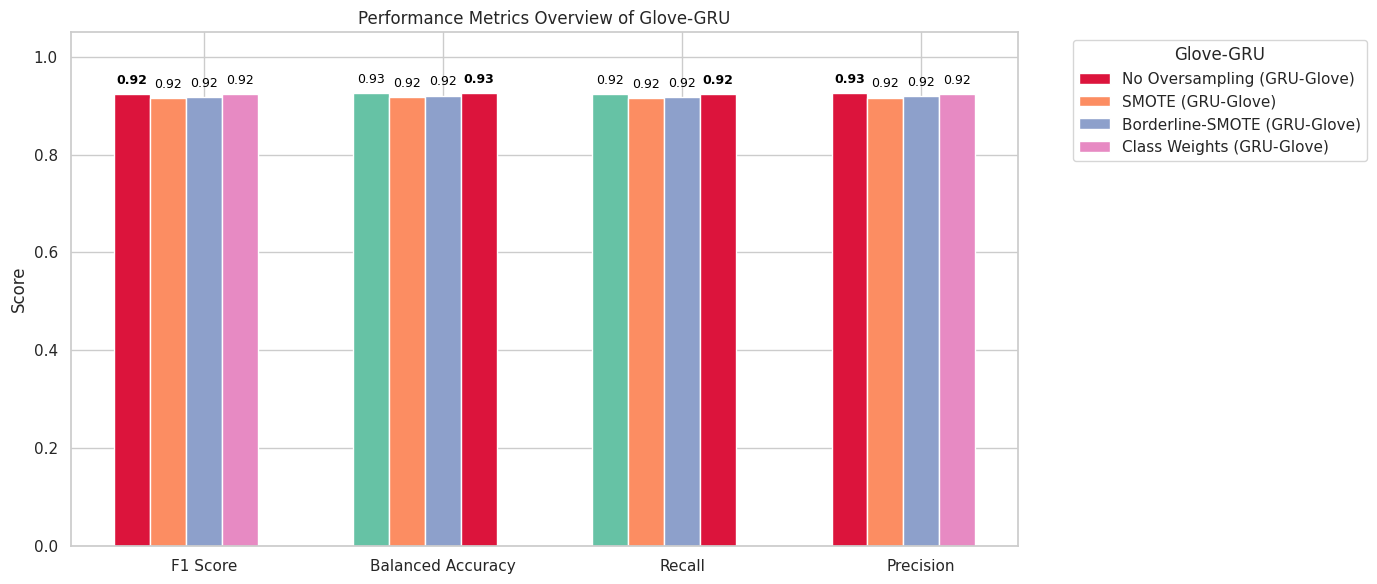

In [ ]:
plot_comparison_histograms(metrics_dict, technique_names=["No Oversampling", "SMOTE", "Borderline-SMOTE", "Class Weights"],model_family_name="Glove-GRU", title=None)

---

---

## **Performance Comparison of Oversampling Techniques across Models**

###a.CNN-LSTM
Observation: All oversampling methods (No Oversampling, SMOTE, Borderline-SMOTE, Class Weights) produce nearly identical results.
Score Range: F1 Score, Balanced Accuracy, Recall, and Precision are all around 0.89–0.90.
**Conclusion**: For the CNN-LSTM architecture, oversampling strategies have little to no effect on the performance metrics.

###b.Glove-GRU
Observation: All oversampling methods again perform very similarly.
Score Range: All metrics hover around 0.92–0.93.
**Conclusion**: Glove-GRU performs very well across the board regardless of the balancing technique used. However, Class Weights slightly edge out others in all metrics.

###c.Glove-GRU-Bahdanau
Observation: Similar to Glove-GRU, all techniques give high and consistent scores.
Score Range: Each metric reaches about 0.92–0.93, with minimal variance.
**Conclusion**: Glove-GRU-Bahdanau achieves consistently high performance, and like with Glove-GRU, Class Weights show the best average across metrics.

**Best Overall Model**: Glove-GRU-Bahdanau with Class Weights consistently ranks at the top.

Oversampling Impact:
Minimal effect on CNN-LSTM.
Slight improvements for GRU-based models, especially using Class Weights.